In [1]:
import numpy as np
from matplotlib import pyplot as plt, cm
import os, sys
sys.path.append('/scratch/valles/masclet_framework')
import masclet_framework as masclet
import g3read as g3
from cython_fortran_file import FortranFile as FF
import pickle, json

from sklearn.neighbors import NearestNeighbors
import findiff
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from tqdm import tqdm
from numba import prange, jit, njit

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
import matplotlib.markers as mmark


from scipy.spatial import KDTree
from scipy.stats import linregress
from numba import jit,njit,prange
from tqdm import tqdm
import pickle

# import curvefit 
from scipy.optimize import curve_fit


# Plot particle distribution and grid

In [2]:
filename='particles_16e6.dat'
npart_bkg = int(.5e6) * 8 #* 8
npart_blobs = int(1.5e6) * 8 #* 8

nblobs = 100
boxsize=1.
Rblobs=0.02
exclude_blobs=0.25

print('Density bkg is: {:.3e}'.format(npart_bkg/boxsize**3))
print('Density of blobs (1-sigma) is: {:.3e}'.format(0.198*npart_blobs/nblobs/(4*np.pi/3*Rblobs**3)))


filepath=os.path.join('test_data/particles/', filename)
if os.path.exists(filepath):
    print('Warning!!! The file already exists. Reading it')
    with open(filepath, 'rb') as f:
        res=pickle.load(f)
        xpart=res['xpart']
        ypart=res['ypart']
        zpart=res['zpart']
        mpart=res['mpart']
        hpart=res['hsml']
        
    print('File read!')
else:
    print('File does not exist!')

Density bkg is: 4.000e+06
Density of blobs (1-sigma) is: 7.090e+08
Warning!!! The file already exists. Reading it
File read!


In [3]:
results_path='test_data/Test 1/realization_2/kC6_ngh356_base256_ref5'

it=0

In [4]:
nx=256
nmax=nx
size=1.
masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

In [5]:
npatch,patchnx,patchny,patchnz,patchx,patchy,patchz,patchrx,patchry,patchrz,pare=\
    masclet.read_masclet.read_grids(it,path=results_path,parameters_path=results_path, read_general=False,
                                    read_dmpartnum=False)

In [6]:
levels = masclet.tools.create_vector_levels(npatch)
levels_field = [l*np.ones((nx,ny,nz)) for l,nx,ny,nz in zip(levels,patchnx,patchny,patchnz)]

In [7]:
ulev, coords = masclet.tools.uniform_grid_zoom_interpolate(levels_field, [-boxsize/2,boxsize/2-boxsize/nmax/2,-boxsize/2,boxsize/2-boxsize/nmax/2,-boxsize/2,boxsize/2-boxsize/nmax/2],
    2, npatch, patchnx,patchny,patchnz,patchrx,patchry,patchrz,boxsize,nx, interpolate=False, return_coords=True)

In [8]:
idx1 = np.where(coords[0]>-boxsize/2)[0][0]
idx2 = np.where(coords[0]<boxsize/2)[0][-1]
print(idx1, idx2)
ulev = ulev[idx1:idx2+1, idx1:idx2+1, idx1:idx2+1]

0 1023


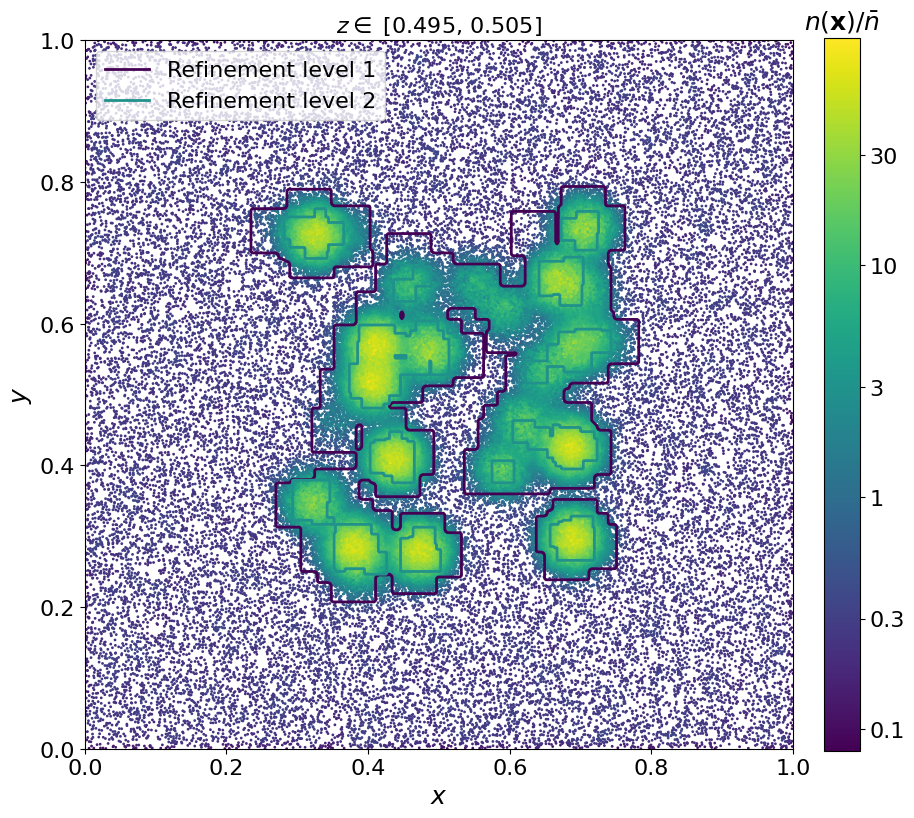

In [10]:
fontsize_big = 18
fontsize_small = 16

plt.figure(figsize=(10,10))
z1=0.495
width=0.01
z2=0.505
if width is not None:
    z2=z1+width
select=(z1 < zpart)*(zpart<z2)
plt.scatter(xpart[select],ypart[select], s=1, 
            c=np.log10(3*58/(4*np.pi)*hpart[select]**(-3) / (zpart.size/boxsize**3))
           # c=hpart[select])
           )
cb=plt.colorbar(fraction=0.046, pad=0.04)
cb.ax.set_yticks(np.log10([.1,.3,1,3,10,30]))
cb.ax.set_yticklabels(['0.1','0.3','1','3','10','30'], fontsize=fontsize_small)
cb.ax.set_title(r'$n(\mathbf{x})/ \bar{n}$', fontsize=fontsize_big)
ax=plt.gca()
ax.set_aspect(1)
ax.set_xlim([0,boxsize])
ax.set_ylim([0,boxsize])

ax.tick_params(labelsize=fontsize_small)
ax.set_title('$z \in$ [{:.3f}, {:.3f}]'.format(z1,z2), fontsize=fontsize_small)
ax.set_xlabel('$x$', fontsize=fontsize_big)
ax.set_ylabel('$y$', fontsize=fontsize_big)

nxuni = ulev.shape[0]
xvec=np.linspace(0, boxsize, nxuni)
yvec=np.linspace(0, boxsize, nxuni)

k1 = int(z1*nxuni/boxsize)
k2 = int(z2*nxuni/boxsize)+1
km = int((k1+k2)/2)

### This is just a dummy thing to remove gaps in the contour, generated by my interpolation in the unigrid
#arr = ulev[:,:,km].copy()
arr = ulev[:,:,k1:k2].max(axis=2)
arr2 = arr.copy()
for i in range(2, nxuni-2):
    for j in range(2, nxuni-2):
        l = arr2[i,j]
        if l==1:
            count = int(arr2[i+1,j]>l) + int(arr2[i-1,j]>l) + int(arr2[i,j+1]>l) + int(arr2[i,j-1]>l)
            if count>=2:
                arr[i,j]=l+1
        elif l==0:
            # go two cells beyond in each direction 
            count = int(arr2[i+2,j]>l) + int(arr2[i-2,j]>l) + int(arr2[i,j+2]>l) + int(arr2[i,j-2]>l) + \
                    int(arr2[i+1,j]>l) + int(arr2[i-1,j]>l) + int(arr2[i,j+1]>l) + int(arr2[i,j-1]>l)
            if count>=2:
                arr[i,j]=l+1
del arr2 
for irepeat in range(3):
    arr2 = arr.copy() 
    for i in range(2, nxuni-2):
        for j in range(2, nxuni-2):
            l = arr2[i,j]
            if l==0:
                count = arr2[i-1:i+2,j-1:j+2].sum()
                if count>=4:
                    arr[i,j]=l+1
del arr2
### End of dummy thing

cs=ax.contour(xvec, yvec, arr.T, levels=[0,1,2], linewidths=2)

plt.legend([Line2D([0], [0], color=cm.viridis(0.), lw=2, label='Level 1'),
            Line2D([0], [0], color=cm.viridis(0.5), lw=2, label='Level 2')],
            ['Refinement level 1', 'Refinement level 2'],
           fontsize=fontsize_small, loc='upper left')
            

#plt.savefig('figures/test_setup_r2.png', dpi=80, bbox_inches='tight')

# Test 1: constant div field

In [11]:
with open('test_data/Test 1/smooth_velocities.dat', 'rb') as f:
    smooth_velocities=pickle.load(f)

In [12]:
things_to_plot = {}

1 5e-07
W4	 58 	 3.51e-04 	 1.38e-04 	 2.60e-04 	 5.22e-04
W4	 137 	 2.93e-04 	 1.11e-04 	 2.07e-04 	 4.10e-04
W4	 356 	 2.87e-04 	 1.02e-04 	 1.91e-04 	 4.01e-04
C4	 58 	 4.14e-04 	 1.51e-04 	 2.96e-04 	 6.51e-04
C4	 137 	 3.31e-04 	 1.29e-04 	 2.42e-04 	 4.83e-04
C4	 356 	 3.01e-04 	 1.12e-04 	 2.08e-04 	 4.30e-04
C6	 58 	 4.58e-04 	 1.57e-04 	 3.16e-04 	 7.45e-04
C6	 137 	 3.57e-04 	 1.38e-04 	 2.63e-04 	 5.36e-04
C6	 356 	 3.10e-04 	 1.17e-04 	 2.19e-04 	 4.47e-04
2 6.25e-08


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator


W4	 58 	 1.63e-04 	 6.96e-05 	 1.31e-04 	 2.47e-04
W4	 137 	 1.23e-04 	 5.37e-05 	 9.82e-05 	 1.79e-04
W4	 356 	 9.60e-05 	 3.75e-05 	 6.94e-05 	 1.35e-04
C4	 58 	 1.97e-04 	 7.54e-05 	 1.50e-04 	 3.08e-04
C4	 137 	 1.47e-04 	 6.40e-05 	 1.19e-04 	 2.20e-04
C4	 356 	 1.11e-04 	 4.66e-05 	 8.53e-05 	 1.61e-04
C6	 58 	 2.19e-04 	 7.77e-05 	 1.59e-04 	 3.51e-04
C6	 137 	 1.63e-04 	 6.89e-05 	 1.30e-04 	 2.48e-04
C6	 356 	 1.22e-04 	 5.21e-05 	 9.55e-05 	 1.77e-04


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator


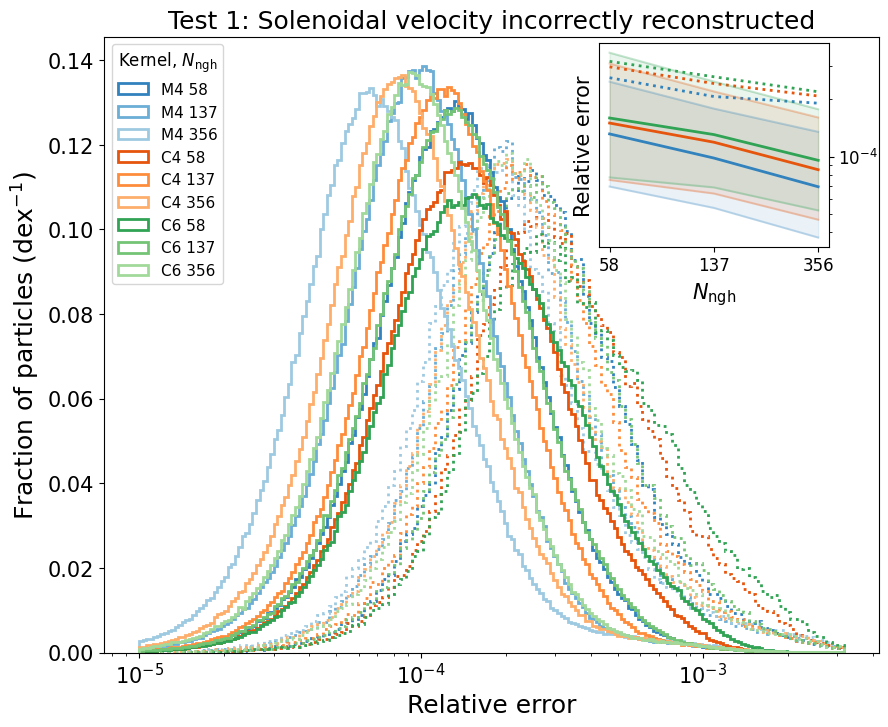

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [9]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.63, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

for irel, nx in zip([1,2], [128,256]):
    things_to_plot[irel]={}
    results_path='test_data/Test 1/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=120
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)
    print(irel, weight)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11

    errmed={}
    errlow={}
    errhigh={}

    for ikernel,kernel in enumerate(kernels):
        things_to_plot[irel][kernel]={}
        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            things_to_plot[irel][kernel][ngh]={}
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')
                res_ypart=f.read_vector('f4')
                res_zpart=f.read_vector('f4')
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)

            err=(np.sqrt(res_vxrot**2+res_vyrot**2+res_vzrot**2)/np.sqrt(res_vxpartori**2+res_vypartori**2+res_vzpartori**2))[select]
            dex_bins=2.5/nbins
            countsbins=ax.hist(err,bins=np.logspace(-5,-2.5,nbins), histtype='step', label=(kernel if kernel!='W4' else 'M4')+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(err.size)/dex_bins, linestyle=linestyle)
            things_to_plot[irel][kernel][ngh]['bins']=countsbins[1]
            things_to_plot[irel][kernel][ngh]['counts']=countsbins[0]
            
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==2:
        ##ax.legend(loc='lower right')
        
        handles, labels = ax.get_legend_handles_labels()
        handles=handles[9:]
        labels=labels[9:]

        #handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        #labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        #handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        #labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        legend = ax.legend(handles, labels, loc='upper left', fontsize=fontsize_smallest, title='Kernel, $N_\mathrm{ngh}$')
        plt.setp(legend.get_title(),fontsize=fontsize_smallest+1)

        

    ax.set_title('Test 1: Solenoidal velocity incorrectly reconstructed', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of particles (dex$^{-1}$)', fontsize=fontsize_big)

    things_to_plot[irel]['errmed']=errmed
    things_to_plot[irel]['errlow']=errlow
    things_to_plot[irel]['errhigh']=errhigh

    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle, lw=2)
        if irel==2:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)
    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")


#fig.savefig('figures/test1_solenoidal_wrt_original.pdf', bbox_inches='tight')

In [11]:
if False: # Save the data (for future figures)
    with open('test_data/Test 1/analysed_results_solenoidal_new.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

In [12]:
things_to_plot = {}

W4	 58 	 5.60e-03 	 4.63e-04 	 8.79e-04 	 1.69e-03
W4	 137 	 5.39e-03 	 3.50e-04 	 6.93e-04 	 1.35e-03
W4	 356 	 6.28e-03 	 5.88e-04 	 1.24e-03 	 2.98e-03
C4	 58 	 5.86e-03 	 5.34e-04 	 1.06e-03 	 2.17e-03
C4	 137 	 5.49e-03 	 4.14e-04 	 7.85e-04 	 1.50e-03
C4	 356 	 5.59e-03 	 4.32e-04 	 8.29e-04 	 1.64e-03
C6	 58 	 5.97e-03 	 5.62e-04 	 1.13e-03 	 2.39e-03
C6	 137 	 5.63e-03 	 4.67e-04 	 8.90e-04 	 1.74e-03
C6	 356 	 5.43e-03 	 3.68e-04 	 7.18e-04 	 1.40e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator


W4	 58 	 2.54e-03 	 2.28e-04 	 4.39e-04 	 8.11e-04
W4	 137 	 2.46e-03 	 1.75e-04 	 3.56e-04 	 6.89e-04
W4	 356 	 2.71e-03 	 2.58e-04 	 5.26e-04 	 1.08e-03
C4	 58 	 2.63e-03 	 2.58e-04 	 5.09e-04 	 9.69e-04
C4	 137 	 2.50e-03 	 2.06e-04 	 3.98e-04 	 7.44e-04
C4	 356 	 2.52e-03 	 2.10e-04 	 4.07e-04 	 7.64e-04
C6	 58 	 2.67e-03 	 2.69e-04 	 5.38e-04 	 1.04e-03
C6	 137 	 2.55e-03 	 2.30e-04 	 4.43e-04 	 8.21e-04
C6	 356 	 2.47e-03 	 1.83e-04 	 3.65e-04 	 7.00e-04


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:192: UserWarning: FixedFormatter should only be used together with FixedLocator


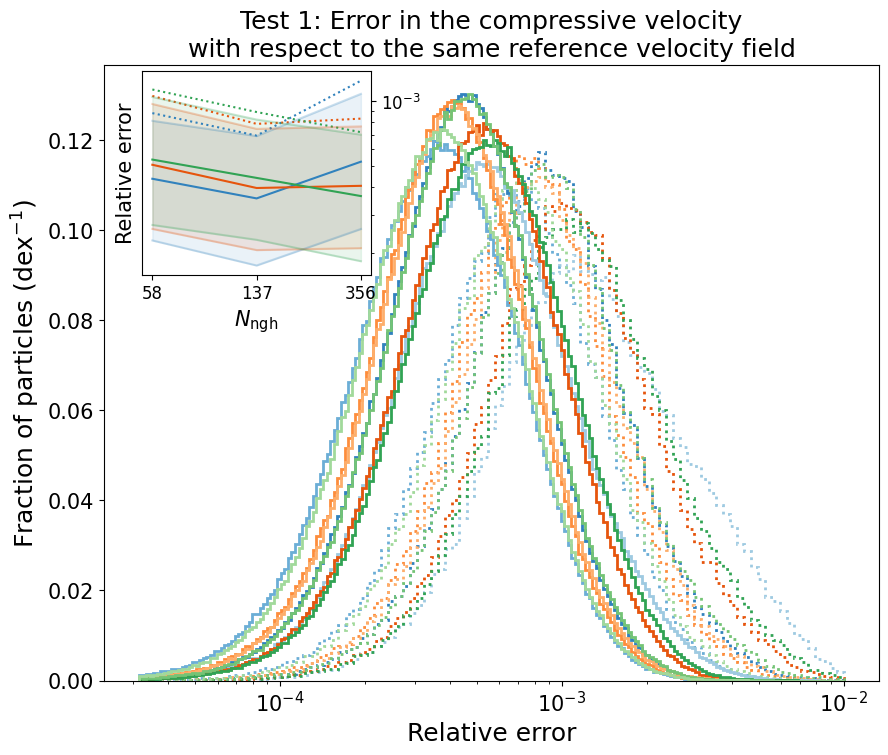

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [112]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.63, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

for irel, nx in zip([1,2], [128,256]):
    things_to_plot[irel]={}
    results_path='test_data/Test 1/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11

    errmed={}
    errlow={}
    errhigh={}

    #### REFERENCE TRUE VELOCITY FOR ERRORS
    kernel='C6'
    ngh=58
    results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')
        res_ypart=f.read_vector('f4')
        res_zpart=f.read_vector('f4')
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

    res_vx_comp_ori = res_vx.copy()
    res_vy_comp_ori = res_vy.copy()
    res_vz_comp_ori = res_vz.copy()
    ####

    for ikernel,kernel in enumerate(kernels):
        things_to_plot[irel][kernel]={}
        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            things_to_plot[irel][kernel][ngh]={}
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')
                res_ypart=f.read_vector('f4')
                res_zpart=f.read_vector('f4')
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)

            if True:
                # error wrt the smoothed velocity by vortex
                vmod2 = res_vx**2 + res_vy**2 + res_vz**2
                epsilon = 0.001*np.sqrt(vmod2.max())
                err=(res_vx**4/vmod2**2)*(res_vxcomp-res_vx)**2/(np.abs(res_vx)+epsilon)**2 + \
                    (res_vy**4/vmod2**2)*(res_vycomp-res_vy)**2/(np.abs(res_vy)+epsilon)**2 + \
                    (res_vz**4/vmod2**2)*(res_vzcomp-res_vz)**2/(np.abs(res_vz)+epsilon)**2
            if False:
                # error wrt the original input velocity and not the smoothed one
                vmod2 = res_vxpartori**2 + res_vypartori**2 + res_vzpartori**2
                epsilon = 0.001*np.sqrt(vmod2.max())
                err=(res_vxpartori**4/vmod2**2)*(res_vxcomp-res_vxpartori)**2/(np.abs(res_vxpartori)+epsilon)**2 + \
                    (res_vypartori**4/vmod2**2)*(res_vycomp-res_vypartori)**2/(np.abs(res_vypartori)+epsilon)**2 + \
                    (res_vzpartori**4/vmod2**2)*(res_vzcomp-res_vzpartori)**2/(np.abs(res_vzpartori)+epsilon)**2
            if False:
                # error wrt the same smoothing always
                kk='C4'
                nn=137
                res_vx = smooth_velocities[irel][kk][nn]['vx']
                res_vy = smooth_velocities[irel][kk][nn]['vy']
                res_vz = smooth_velocities[irel][kk][nn]['vz']
                vmod2 = res_vx**2 + res_vy**2 + res_vz**2
                epsilon = 0.001*np.sqrt(vmod2.max())
                err=(res_vx**4/vmod2**2)*(res_vxcomp-res_vx)**2/(np.abs(res_vx)+epsilon)**2 + \
                    (res_vy**4/vmod2**2)*(res_vycomp-res_vy)**2/(np.abs(res_vy)+epsilon)**2 + \
                    (res_vz**4/vmod2**2)*(res_vzcomp-res_vz)**2/(np.abs(res_vz)+epsilon)**2
            if False:
                # error wrt the smoothed velocity here
                res_vx = smooth_velocities[irel][kernel][ngh]['vx']
                res_vy = smooth_velocities[irel][kernel][ngh]['vy']
                res_vz = smooth_velocities[irel][kernel][ngh]['vz']
                vmod2 = res_vx**2 + res_vy**2 + res_vz**2
                epsilon = 0.001*np.sqrt(vmod2.max())
                err=(res_vx**4/vmod2**2)*(res_vxcomp-res_vx)**2/(np.abs(res_vx)+epsilon)**2 + \
                    (res_vy**4/vmod2**2)*(res_vycomp-res_vy)**2/(np.abs(res_vy)+epsilon)**2 + \
                    (res_vz**4/vmod2**2)*(res_vzcomp-res_vz)**2/(np.abs(res_vz)+epsilon)**2

            err=np.sqrt(err)
            err=err[select]
            dex_bins=2.5/nbins
            histcounts=ax.hist(err,bins=np.logspace(-4.5,-2, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(err.size)/dex_bins, linestyle=linestyle)
            things_to_plot[irel][kernel][ngh]['bins']=histcounts[1]
            things_to_plot[irel][kernel][ngh]['counts']=histcounts[0]
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==2:
        #ax.legend(loc='lower right')
        #handles, labels = ax.get_legend_handles_labels()
        handles = []
        labels = []
        handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        labels.append(r'$N_\mathrm{part}= 16 \times 10^6$')

        #ax.legend(handles, labels, loc='upper left', fontsize=fontsize_smallest)

    things_to_plot[irel]['errmed']=errmed
    things_to_plot[irel]['errlow']=errlow
    things_to_plot[irel]['errhigh']=errhigh
        

    ax.set_title('Test 1: Error in the compressive velocity\nwith respect to the same reference velocity field', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of particles (dex$^{-1}$)', fontsize=fontsize_big)

    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==2:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

# fig.savefig('figures/test1_compressive.pdf', bbox_inches='tight')

In [14]:
if False: # Save the data (for future figures)
    with open('test_data/Test 1/analysed_results_compressive_new.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

# Test 2: constant curl field

In [51]:
with open('test_data/Test 2/smooth_velocities.dat', 'rb') as f:
    smooth_velocities=pickle.load(f)

In [52]:
things_to_plot = {}

W4	 58 	 2.57e-04 	 9.46e-05 	 1.86e-04 	 3.94e-04
W4	 137 	 2.06e-04 	 7.47e-05 	 1.43e-04 	 2.95e-04
W4	 356 	 1.90e-04 	 6.14e-05 	 1.19e-04 	 2.69e-04
C4	 58 	 3.13e-04 	 1.05e-04 	 2.18e-04 	 5.04e-04
C4	 137 	 2.38e-04 	 8.80e-05 	 1.71e-04 	 3.58e-04
C4	 356 	 2.05e-04 	 7.13e-05 	 1.37e-04 	 2.97e-04
C6	 58 	 3.52e-04 	 1.10e-04 	 2.36e-04 	 5.82e-04
C6	 137 	 2.61e-04 	 9.50e-05 	 1.87e-04 	 4.04e-04
C6	 356 	 2.15e-04 	 7.67e-05 	 1.47e-04 	 3.15e-04


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator


W4	 58 	 1.17e-04 	 4.70e-05 	 9.05e-05 	 1.79e-04
W4	 137 	 8.60e-05 	 3.60e-05 	 6.70e-05 	 1.26e-04
W4	 356 	 6.47e-05 	 2.46e-05 	 4.64e-05 	 9.18e-05
C4	 58 	 1.45e-04 	 5.11e-05 	 1.04e-04 	 2.27e-04
C4	 137 	 1.05e-04 	 4.31e-05 	 8.16e-05 	 1.58e-04
C4	 356 	 7.66e-05 	 3.09e-05 	 5.78e-05 	 1.12e-04
C6	 58 	 1.63e-04 	 5.27e-05 	 1.12e-04 	 2.62e-04
C6	 137 	 1.17e-04 	 4.65e-05 	 8.99e-05 	 1.80e-04
C6	 356 	 8.46e-05 	 3.48e-05 	 6.51e-05 	 1.25e-04


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:127: UserWarning: FixedFormatter should only be used together with FixedLocator


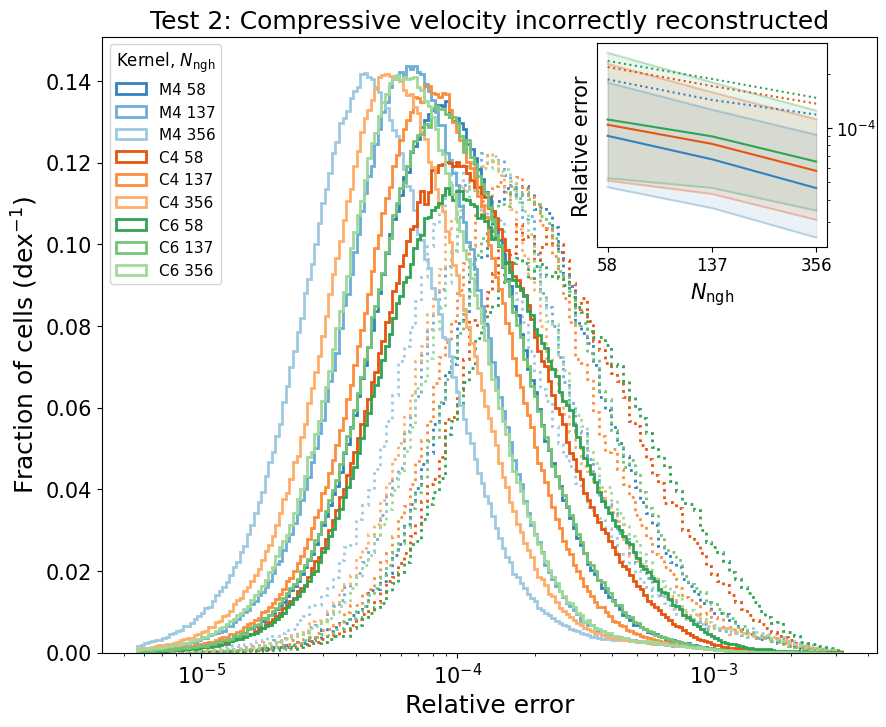

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [53]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.63, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

for irel, nx in zip([1,2], [128,256]):
    things_to_plot[irel]={}
    results_path='test_data/Test 2/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=120
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11

    errmed={}
    errlow={}
    errhigh={}

    for ikernel,kernel in enumerate(kernels):
        things_to_plot[irel][kernel]={}
        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            things_to_plot[irel][kernel][ngh]={}
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')
                res_ypart=f.read_vector('f4')
                res_zpart=f.read_vector('f4')
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)

            err=(np.sqrt(res_vxcomp**2+res_vycomp**2+res_vzcomp**2)/np.sqrt(res_vxpartori**2+res_vypartori**2+res_vzpartori**2))[select]
            dex_bins=2.5/nbins
            histcounts=ax.hist(err,bins=np.logspace(-5.25,-2.5,nbins), histtype='step', label=(kernel if kernel!='W4' else 'M4')+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(err.size)/dex_bins, linestyle=linestyle)
            things_to_plot[irel][kernel][ngh]['bins']=histcounts[1]
            things_to_plot[irel][kernel][ngh]['counts']=histcounts[0]
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==2:
        #ax.legend(loc='lower right')
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[9:]
        labels = labels[9:]

        #handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        #labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        #handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        #labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        legend = ax.legend(handles, labels, loc='upper left', fontsize=fontsize_smallest, title='Kernel, $N_\mathrm{ngh}$')
        plt.setp(legend.get_title(),fontsize=fontsize_smallest+1)

        
    things_to_plot[irel]['errmed']=errmed
    things_to_plot[irel]['errlow']=errlow
    things_to_plot[irel]['errhigh']=errhigh

    ax.set_title('Test 2: Compressive velocity incorrectly reconstructed', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==2:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=3e-4 else r'$3 \times 10^{-4}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

# fig.savefig('figures/test2_compressive.pdf', bbox_inches='tight')

In [17]:
if False: # Save the data (for future figures)
    with open('test_data/Test 2/analysed_results_compressive_new.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

In [18]:
things_to_plot = {}

W4	 58 	 4.99e-03 	 3.44e-04 	 7.61e-04 	 1.55e-03
W4	 137 	 4.81e-03 	 2.89e-04 	 6.39e-04 	 1.26e-03
W4	 356 	 4.61e-03 	 2.13e-04 	 4.91e-04 	 9.72e-04
C4	 58 	 5.09e-03 	 3.51e-04 	 7.99e-04 	 1.73e-03
C4	 137 	 4.93e-03 	 3.27e-04 	 7.19e-04 	 1.44e-03
C4	 356 	 4.72e-03 	 2.56e-04 	 5.78e-04 	 1.14e-03
C6	 58 	 5.16e-03 	 3.53e-04 	 8.16e-04 	 1.86e-03
C6	 137 	 4.99e-03 	 3.40e-04 	 7.55e-04 	 1.54e-03
C6	 356 	 4.80e-03 	 2.84e-04 	 6.28e-04 	 1.24e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator


W4	 58 	 2.17e-03 	 1.51e-04 	 3.57e-04 	 7.53e-04
W4	 137 	 2.08e-03 	 1.27e-04 	 2.96e-04 	 6.12e-04
W4	 356 	 1.97e-03 	 8.90e-05 	 2.14e-04 	 4.53e-04
C4	 58 	 2.21e-03 	 1.54e-04 	 3.74e-04 	 8.29e-04
C4	 137 	 2.13e-03 	 1.43e-04 	 3.36e-04 	 7.00e-04
C4	 356 	 2.03e-03 	 1.11e-04 	 2.61e-04 	 5.44e-04
C6	 58 	 2.24e-03 	 1.53e-04 	 3.80e-04 	 8.77e-04
C6	 137 	 2.16e-03 	 1.49e-04 	 3.53e-04 	 7.46e-04
C6	 356 	 2.07e-03 	 1.23e-04 	 2.88e-04 	 5.96e-04


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator


W4	 58 	 1.35e-03 	 7.45e-05 	 1.73e-04 	 3.72e-04
W4	 137 	 1.30e-03 	 6.08e-05 	 1.39e-04 	 2.89e-04
W4	 356 	 1.24e-03 	 4.09e-05 	 9.70e-05 	 2.06e-04
C4	 58 	 1.38e-03 	 7.72e-05 	 1.86e-04 	 4.25e-04
C4	 137 	 1.33e-03 	 7.01e-05 	 1.61e-04 	 3.39e-04
C4	 356 	 1.28e-03 	 5.24e-05 	 1.21e-04 	 2.52e-04
C6	 58 	 1.40e-03 	 7.75e-05 	 1.91e-04 	 4.61e-04
C6	 137 	 1.35e-03 	 7.38e-05 	 1.71e-04 	 3.69e-04
C6	 356 	 1.29e-03 	 5.88e-05 	 1.35e-04 	 2.79e-04


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:184: UserWarning: FixedFormatter should only be used together with FixedLocator


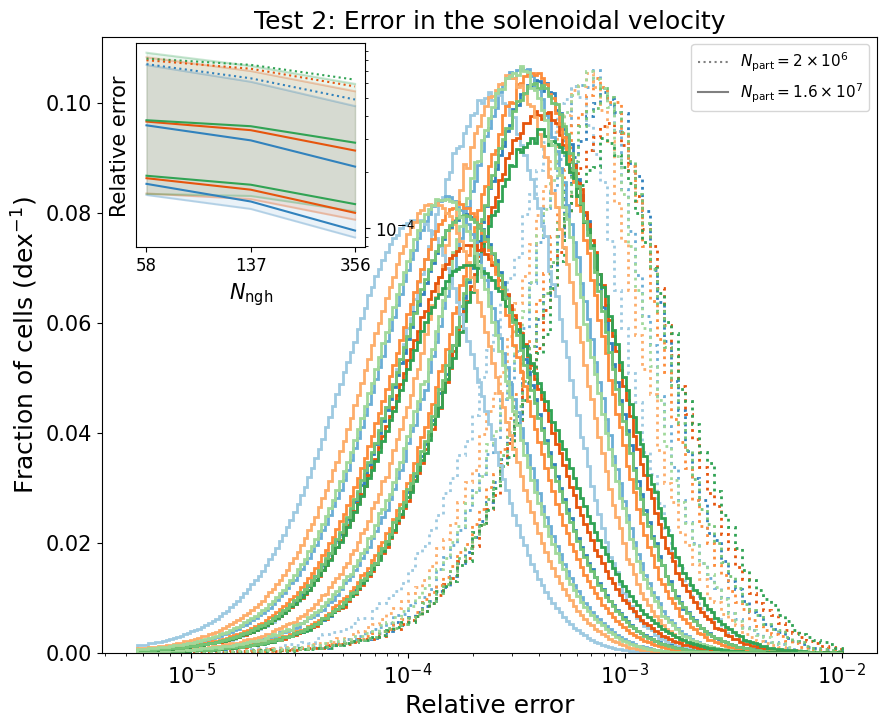

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [19]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            #bbox_to_anchor=(0.63, 0.4,0.8,0.6),
            bbox_to_anchor=(0.035, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

for irel, nx in zip([1,2,3], [128,256,512]):
    things_to_plot[irel]={}
    results_path='test_data/Test 2/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11

    errmed={}
    errlow={}
    errhigh={}

    #### REFERENCE TRUE VELOCITY FOR ERRORS
    kernel='C6'
    ngh=58
    results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')
        res_ypart=f.read_vector('f4')
        res_zpart=f.read_vector('f4')
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

    res_vx_comp_ori = res_vx.copy()
    res_vy_comp_ori = res_vy.copy()
    res_vz_comp_ori = res_vz.copy()
    ####

    for ikernel,kernel in enumerate(kernels):
        things_to_plot[irel][kernel]={}
        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            things_to_plot[irel][kernel][ngh]={}
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')
                res_ypart=f.read_vector('f4')
                res_zpart=f.read_vector('f4')
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)

            if True:
                # error wrt the smoothed velocity by vortex
                vmod2 = res_vx**2 + res_vy**2 + res_vz**2
                epsilon = 0.001*np.sqrt(vmod2.max())
                err=(res_vx**4/vmod2**2)*(res_vxrot-res_vx)**2/(np.abs(res_vx)+epsilon)**2 + \
                    (res_vy**4/vmod2**2)*(res_vyrot-res_vy)**2/(np.abs(res_vy)+epsilon)**2 + \
                    (res_vz**4/vmod2**2)*(res_vzrot-res_vz)**2/(np.abs(res_vz)+epsilon)**2
            if False:
                # error wrt the original input velocity and not the smoothed one
                vmod2 = res_vxpartori**2 + res_vypartori**2 + res_vzpartori**2
                epsilon = 0.001*np.sqrt(vmod2.max())
                err=(res_vxpartori**4/vmod2**2)*(res_vxrot-res_vxpartori)**2/(np.abs(res_vxpartori)+epsilon)**2 + \
                    (res_vypartori**4/vmod2**2)*(res_vyrot-res_vypartori)**2/(np.abs(res_vypartori)+epsilon)**2 + \
                    (res_vzpartori**4/vmod2**2)*(res_vzrot-res_vzpartori)**2/(np.abs(res_vzpartori)+epsilon)**2
            if False:
                # error wrt the smoothed velocity here
                res_vx = smooth_velocities[irel][kernel][ngh]['vx']
                res_vy = smooth_velocities[irel][kernel][ngh]['vy']
                res_vz = smooth_velocities[irel][kernel][ngh]['vz']

                vmod2 = res_vx**2 + res_vy**2 + res_vz**2
                epsilon = 0.001*np.sqrt(vmod2.max())
                err=(res_vx**4/vmod2**2)*(res_vxrot-res_vx)**2/(np.abs(res_vx)+epsilon)**2 + \
                    (res_vy**4/vmod2**2)*(res_vyrot-res_vy)**2/(np.abs(res_vy)+epsilon)**2 + \
                    (res_vz**4/vmod2**2)*(res_vzrot-res_vz)**2/(np.abs(res_vz)+epsilon)**2


            err=np.sqrt(err)
            err=err[select]
            dex_bins=3.25/nbins
            histcounts=ax.hist(err,bins=np.logspace(-5.25,-2, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(err.size)/dex_bins, linestyle=linestyle)
            things_to_plot[irel][kernel][ngh]['bins']=histcounts[1]
            things_to_plot[irel][kernel][ngh]['counts']=histcounts[0]
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==1:
        #ax.legend(loc='lower right')
        #handles, labels = ax.get_legend_handles_labels()
        handles = []
        labels = []

        handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        ax.legend(handles, labels, loc='upper right', fontsize=fontsize_smallest)

        
    things_to_plot[irel]['errmed']=errmed
    things_to_plot[irel]['errlow']=errlow
    things_to_plot[irel]['errhigh']=errhigh

    ax.set_title('Test 2: Error in the solenoidal velocity', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==2:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

#fig.savefig('figures/test2_solenoidal.pdf', bbox_inches='tight')

In [20]:
if False: # Save the data (for future figures)
    with open('test_data/Test 2/analysed_results_solenoidal_new.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

# Test 3: mixed (compressive/solenoidal) field

In [13]:
with open('test_data/Test 3/smooth_velocities.dat', 'rb') as f:
    smooth_velocities=pickle.load(f)

KeyboardInterrupt: 

In [24]:
things_to_plot = {}

W4	 58 	 6.79e-03 	 2.55e-03 	 4.99e-03 	 9.88e-03
W4	 137 	 8.21e-03 	 3.37e-03 	 6.53e-03 	 1.18e-02
W4	 356 	 1.16e-02 	 4.63e-03 	 9.55e-03 	 1.71e-02
C4	 58 	 6.09e-03 	 2.04e-03 	 4.18e-03 	 8.97e-03
C4	 137 	 6.95e-03 	 2.56e-03 	 5.04e-03 	 1.01e-02
C4	 356 	 9.60e-03 	 3.72e-03 	 7.29e-03 	 1.37e-02
C6	 58 	 5.99e-03 	 1.87e-03 	 3.97e-03 	 8.90e-03
C6	 137 	 6.78e-03 	 2.30e-03 	 4.62e-03 	 9.94e-03
C6	 356 	 9.41e-03 	 3.37e-03 	 6.68e-03 	 1.37e-02


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator


W4	 58 	 2.64e-03 	 7.37e-04 	 1.64e-03 	 4.00e-03
W4	 137 	 2.78e-03 	 9.17e-04 	 1.93e-03 	 4.05e-03
W4	 356 	 3.58e-03 	 1.30e-03 	 2.77e-03 	 5.14e-03
C4	 58 	 2.56e-03 	 6.42e-04 	 1.51e-03 	 3.94e-03
C4	 137 	 2.56e-03 	 7.41e-04 	 1.62e-03 	 3.85e-03
C4	 356 	 3.10e-03 	 1.03e-03 	 2.17e-03 	 4.52e-03
C6	 58 	 2.59e-03 	 6.13e-04 	 1.50e-03 	 4.02e-03
C6	 137 	 2.58e-03 	 6.80e-04 	 1.55e-03 	 3.96e-03
C6	 356 	 3.09e-03 	 9.17e-04 	 1.99e-03 	 4.64e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:182: UserWarning: FixedFormatter should only be used together with FixedLocator


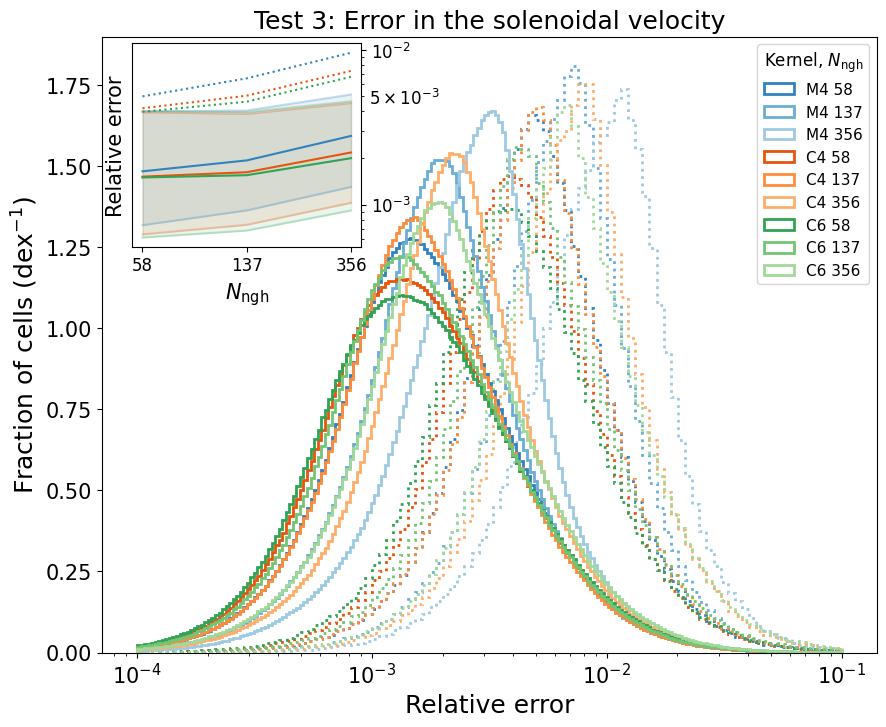

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [55]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.03, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

for irel, nx in zip([1,2], [128,256]):
    things_to_plot[irel]={}
    results_path='test_data/Test 3/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11

    errmed={}
    errlow={}
    errhigh={}

    #### REFERENCE TRUE VELOCITY FOR ERRORS
    kernel='C6'
    ngh=58
    results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')
        res_ypart=f.read_vector('f4')
        res_zpart=f.read_vector('f4')
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

    res_vx_comp_ori = res_vx.copy()
    res_vy_comp_ori = res_vy.copy()
    res_vz_comp_ori = res_vz.copy()
    ####

    for ikernel,kernel in enumerate(kernels):
        things_to_plot[irel][kernel]={}
        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            things_to_plot[irel][kernel][ngh]={}
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')+size/2
                res_ypart=f.read_vector('f4')+size/2
                res_zpart=f.read_vector('f4')+size/2
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')

                vxpart = np.sin(2*np.pi*res_xpart) + np.sin(4*np.pi*res_ypart) + np.sin(6*np.pi*res_zpart)
                vypart = np.sin(6*np.pi*res_xpart) + np.sin(2*np.pi*res_ypart) + np.sin(4*np.pi*res_zpart)
                vzpart = np.sin(4*np.pi*res_xpart) + np.sin(6*np.pi*res_ypart) + np.sin(2*np.pi*res_zpart)

                #vxpartcomp = np.sin(2*np.pi*res_xpart)
                #vxpartsol = res_vxpartori - vxpartcomp
                #vypartcomp = np.sin(2*np.pi*res_ypart)
                #vypartsol = res_vypartori - vypartcomp
                #vzpartcomp = np.sin(2*np.pi*res_zpart)
                #vzpartsol = res_vzpartori - vzpartcomp

                vxpartcomp = smooth_velocities[irel][kernel][ngh]['vx_conp']
                vypartcomp = smooth_velocities[irel][kernel][ngh]['vy_conp']
                vzpartcomp = smooth_velocities[irel][kernel][ngh]['vz_conp']
                vxpartsol = smooth_velocities[irel][kernel][ngh]['vx_sol']
                vypartsol = smooth_velocities[irel][kernel][ngh]['vy_sol']
                vzpartsol = smooth_velocities[irel][kernel][ngh]['vz_sol']
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)

            # error wrt the original input velocity and not the smoothed one
            vmod2 = vxpartsol**2 + vypartsol**2 + vzpartsol**2
            epsilon = 0.001*np.sqrt(vmod2.max())
            err=(vxpartsol**4/vmod2**2)*(res_vxrot-vxpartsol)**2/(np.abs(vxpartsol)+epsilon)**2 + \
                (vypartsol**4/vmod2**2)*(res_vyrot-vypartsol)**2/(np.abs(vypartsol)+epsilon)**2 + \
                (vzpartsol**4/vmod2**2)*(res_vzrot-vzpartsol)**2/(np.abs(vzpartsol)+epsilon)**2


            err=np.sqrt(err)
            err=err[select]
            dex_bins=2.5/nbins
            histcounts=ax.hist(err,bins=np.logspace(-4,-1, nbins), histtype='step', label=(kernel if kernel!='W4' else 'M4')+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(err.size)/dex_bins, linestyle=linestyle)
            things_to_plot[irel][kernel][ngh]['bins']=histcounts[1]
            things_to_plot[irel][kernel][ngh]['counts']=histcounts[0]
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==2:
        #ax.legend(loc='lower right')
        handles, labels = ax.get_legend_handles_labels()
        handles = handles[9:]
        labels = labels[9:]

        #handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        #labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        #handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        #labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        legend = ax.legend(handles, labels, loc='upper right', fontsize=fontsize_smallest, title='Kernel, $N_\mathrm{ngh}$')
        plt.setp(legend.get_title(),fontsize=fontsize_smallest+1)

    things_to_plot[irel]['errmed']=errmed
    things_to_plot[irel]['errlow']=errlow
    things_to_plot[irel]['errhigh']=errhigh

    ax.set_title('Test 3: Error in the solenoidal velocity', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==2:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

#fig.savefig('figures/test3_solenoidal.pdf', bbox_inches='tight')

In [26]:
if False: # Save the data (for future figures)
    with open('test_data/Test 3/analysed_results_solenoidal_new.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

In [27]:
things_to_plot = {}

W4	 58 	 4.74e-03 	 2.16e-03 	 3.92e-03 	 7.04e-03
W4	 137 	 6.70e-03 	 3.31e-03 	 5.98e-03 	 9.73e-03
W4	 356 	 1.04e-02 	 5.08e-03 	 9.59e-03 	 1.51e-02
C4	 58 	 3.83e-03 	 1.58e-03 	 2.91e-03 	 5.85e-03
C4	 137 	 5.08e-03 	 2.39e-03 	 4.33e-03 	 7.49e-03
C4	 356 	 7.52e-03 	 3.73e-03 	 6.81e-03 	 1.09e-02
C6	 58 	 3.51e-03 	 1.36e-03 	 2.53e-03 	 5.46e-03
C6	 137 	 4.49e-03 	 2.01e-03 	 3.66e-03 	 6.69e-03
C6	 356 	 6.45e-03 	 3.14e-03 	 5.72e-03 	 9.37e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator


W4	 58 	 1.71e-03 	 6.26e-04 	 1.23e-03 	 2.68e-03
W4	 137 	 2.25e-03 	 9.72e-04 	 1.86e-03 	 3.43e-03
W4	 356 	 3.41e-03 	 1.59e-03 	 2.98e-03 	 5.19e-03
C4	 58 	 1.49e-03 	 4.82e-04 	 9.70e-04 	 2.38e-03
C4	 137 	 1.81e-03 	 7.06e-04 	 1.37e-03 	 2.80e-03
C4	 356 	 2.56e-03 	 1.16e-03 	 2.18e-03 	 3.88e-03
C6	 58 	 1.41e-03 	 4.29e-04 	 8.74e-04 	 2.29e-03
C6	 137 	 1.65e-03 	 6.01e-04 	 1.18e-03 	 2.58e-03
C6	 356 	 2.24e-03 	 9.74e-04 	 1.86e-03 	 3.41e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator


W4	 58 	 6.82e-04 	 2.03e-04 	 4.06e-04 	 1.11e-03
W4	 137 	 7.93e-04 	 2.94e-04 	 5.61e-04 	 1.24e-03
W4	 356 	 1.08e-03 	 4.90e-04 	 8.98e-04 	 1.63e-03
C4	 58 	 6.32e-04 	 1.68e-04 	 3.45e-04 	 1.06e-03
C4	 137 	 6.92e-04 	 2.22e-04 	 4.35e-04 	 1.11e-03
C4	 356 	 8.66e-04 	 3.53e-04 	 6.62e-04 	 1.33e-03
C6	 58 	 6.16e-04 	 1.55e-04 	 3.24e-04 	 1.04e-03
C6	 137 	 6.58e-04 	 1.94e-04 	 3.87e-04 	 1.07e-03
C6	 356 	 7.89e-04 	 2.97e-04 	 5.65e-04 	 1.23e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:181: UserWarning: FixedFormatter should only be used together with FixedLocator


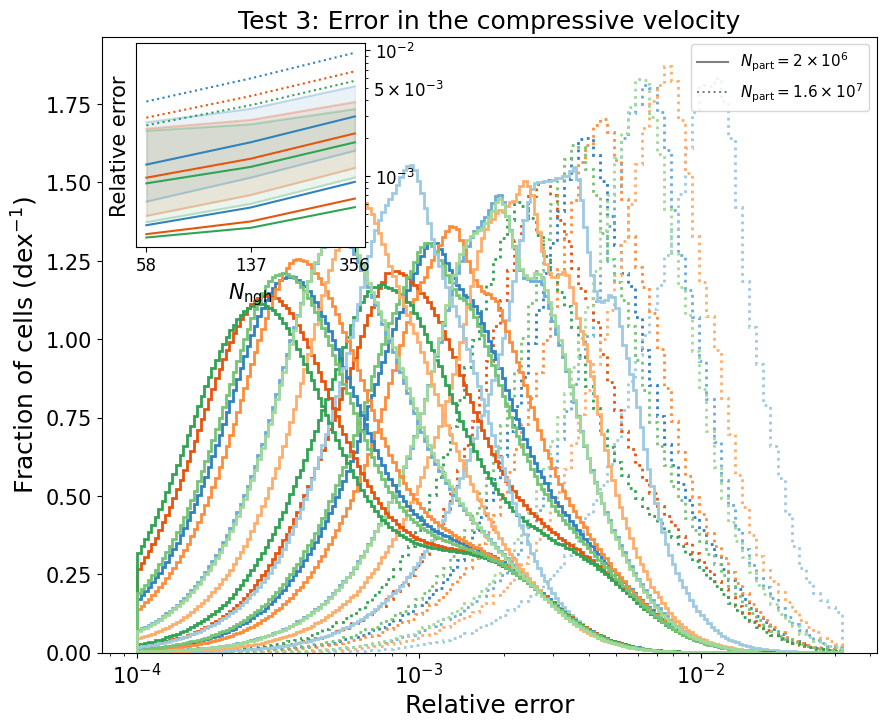

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [28]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.035, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

for irel, nx in zip([1,2,3], [128,256,512]):
    things_to_plot[irel]={}
    results_path='test_data/Test 3/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11

    errmed={}
    errlow={}
    errhigh={}

    #### REFERENCE TRUE VELOCITY FOR ERRORS
    kernel='C6'
    ngh=58
    results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')
        res_ypart=f.read_vector('f4')
        res_zpart=f.read_vector('f4')
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

    res_vx_comp_ori = res_vx.copy()
    res_vy_comp_ori = res_vy.copy()
    res_vz_comp_ori = res_vz.copy()
    ####

    for ikernel,kernel in enumerate(kernels):
        things_to_plot[irel][kernel]={}
        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            things_to_plot[irel][kernel][ngh]={}
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')+size/2
                res_ypart=f.read_vector('f4')+size/2
                res_zpart=f.read_vector('f4')+size/2
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')

                vxpart = np.sin(2*np.pi*res_xpart) + np.sin(4*np.pi*res_ypart) + np.sin(6*np.pi*res_zpart)
                vypart = np.sin(6*np.pi*res_xpart) + np.sin(2*np.pi*res_ypart) + np.sin(4*np.pi*res_zpart)
                vzpart = np.sin(4*np.pi*res_xpart) + np.sin(6*np.pi*res_ypart) + np.sin(2*np.pi*res_zpart)

                vxpartcomp = np.sin(2*np.pi*res_xpart)
                vxpartsol = res_vxpartori - vxpartcomp
                vypartcomp = np.sin(2*np.pi*res_ypart)
                vypartsol = res_vypartori - vypartcomp
                vzpartcomp = np.sin(2*np.pi*res_zpart)
                vzpartsol = res_vzpartori - vzpartcomp

                vxpartcomp = smooth_velocities[irel][kernel][ngh]['vx_conp']
                vypartcomp = smooth_velocities[irel][kernel][ngh]['vy_conp']
                vzpartcomp = smooth_velocities[irel][kernel][ngh]['vz_conp']
                vxpartsol = smooth_velocities[irel][kernel][ngh]['vx_sol']
                vypartsol = smooth_velocities[irel][kernel][ngh]['vy_sol']
                vzpartsol = smooth_velocities[irel][kernel][ngh]['vz_sol']
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)

            # error wrt the original input velocity and not the smoothed one
            vmod2 = vxpartcomp**2 + vypartcomp**2 + vzpartcomp**2
            epsilon = 0.001*np.sqrt(vmod2.max())
            err=(vxpartcomp**4/vmod2**2)*(res_vxcomp-vxpartcomp)**2/(np.abs(vxpartcomp)+epsilon)**2 + \
                (vypartcomp**4/vmod2**2)*(res_vycomp-vypartcomp)**2/(np.abs(vypartcomp)+epsilon)**2 + \
                (vzpartcomp**4/vmod2**2)*(res_vzcomp-vzpartcomp)**2/(np.abs(vzpartcomp)+epsilon)**2


            err=np.sqrt(err)
            err=err[select]
            dex_bins=2.5/nbins
            histcounts=ax.hist(err,bins=np.logspace(-4,-1.5, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(err.size)/dex_bins, linestyle=linestyle)
            things_to_plot[irel][kernel][ngh]['bins']=histcounts[1]
            things_to_plot[irel][kernel][ngh]['counts']=histcounts[0]
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==1:
        #ax.legend(loc='lower right')
        #handles, labels = ax.get_legend_handles_labels()
        handles = []
        labels = []

        handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        ax.legend(handles, labels, loc='upper right', fontsize=fontsize_smallest)

    things_to_plot[irel]['errmed']=errmed
    things_to_plot[irel]['errlow']=errlow
    things_to_plot[irel]['errhigh']=errhigh

    ax.set_title('Test 3: Error in the compressive velocity', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==2:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

#fig.savefig('figures/test3_compressive.pdf', bbox_inches='tight')

In [29]:
if False: # Save the data (for future figures)    
    with open('test_data/Test 3/analysed_results_compressive_new.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

## Eror map

In [465]:
kernel='C6'
ngh=58
results_path = 'test_data/Test 3/realization_1'
nx = 128

results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base128_ref5'.format(ngh))

npatch,patchnx,patchny,patchnz,patchx,patchy,patchz,patchrx,patchry,patchrz,pare=\
    masclet.read_masclet.read_grids(it,path=results_path2,parameters_path=results_path, read_general=False,
                                    read_dmpartnum=False)

div,rotx,roty,rotz,spot,vpotx,vpoty,vpotz,\
 vcompx,vcompy,vcompz,vrotx,vroty,vrotz=masclet.read_masclet.read_vortex(it,path=results_path2,grids_path=results_path2,parameters_path=results_path,
                                 are_divrot=True,are_potentials=True,is_header=True)

with FF(os.path.join(results_path2, 'gridvars{:05d}'.format(it)), 'r') as f:
    L0=[np.reshape(f.read_vector('f4'),(nx,nx,nx),'F')]
    u2=[np.reshape(f.read_vector('f4'),(nx,nx,nx),'F')]
    u3=[np.reshape(f.read_vector('f4'),(nx,nx,nx),'F')]
    u4=[np.reshape(f.read_vector('f4'),(nx,nx,nx),'F')]
    _=f.read_vector('f4')
    cr0amr=[np.reshape(f.read_vector('i4'),(nx,nx,nx),'F')]
    solapst=[np.ones(cr0amr[0].shape)]
    
    for ipatch in range(1,npatch.sum()+1):
        L0.append(np.reshape(f.read_vector('f4'),(patchnx[ipatch],patchny[ipatch],patchnz[ipatch]),'F'))
        u2.append(np.reshape(f.read_vector('f4'),(patchnx[ipatch],patchny[ipatch],patchnz[ipatch]),'F'))
        u3.append(np.reshape(f.read_vector('f4'),(patchnx[ipatch],patchny[ipatch],patchnz[ipatch]),'F'))
        u4.append(np.reshape(f.read_vector('f4'),(patchnx[ipatch],patchny[ipatch],patchnz[ipatch]),'F'))
        _=f.read_vector('f4')
        cr0amr.append(np.reshape(f.read_vector('i4'),(patchnx[ipatch],patchny[ipatch],patchnz[ipatch]),'F'))
        solapst.append(np.reshape(f.read_vector('i4'),(patchnx[ipatch],patchny[ipatch],patchnz[ipatch]),'F'))
        
        
cellsrx,cellsry,cellsrz=masclet.tools_xyz.compute_position_fields(patchnx,patchny,patchnz,patchrx,patchry,patchrz,npatch,size,nx,ncores=8)
cellsrx = [x+size/2 for x in cellsrx]
cellsry = [y+size/2 for y in cellsry]
cellsrz = [z+size/2 for z in cellsrz]

In [466]:
vxcompinput = [np.sin(2*np.pi*xxx) for xxx in cellsrx]
vycompinput = [np.sin(2*np.pi*yyy) for yyy in cellsry]
vzcompinput = [np.sin(2*np.pi*zzz) for zzz in cellsrz]
errfield = [(xout-xin) for xin, xout in zip(vxcompinput, vcompx)]
eps = 0.01 * np.sqrt(max([(vxi**2 + vyi**2 + vzi**2).max() for vxi,vyi,vzi in zip(vxcompinput, vycompinput, vzcompinput)]))
errfield = [(vxi**4 * (vxi-vxo)**2 / (vxi**2 + eps**2) +
             vyi**4 * (vyi-vyo)**2 / (vyi**2 + eps**2) +
             vzi**4 * (vzi-vzo)**2 / (vzi**2 + eps**2)) 
            / (vxi**2 + vyi**2 + vzi**2)**2  for vxi,vyi,vzi,vxo,vyo,vzo in zip(vxcompinput,vycompinput,vzcompinput,vcompx,vcompy,vcompz)]
errfield = [np.sqrt(err) for err in errfield]

In [397]:
utl=2
bbox=[-.5,.5,-.5,.5,-.5,.5]

In [381]:
ulev = masclet.tools.uniform_grid_zoom_parallel(masclet.tools.clean_field([l*np.ones(a.shape) for a,l in zip(u2,masclet.tools.create_vector_levels(npatch))],
                                                                       cr0amr,solapst,npatch,up_to_level=utl),
                                             bbox,utl,
                                             npatch,patchnx,patchny,patchnz,patchrx,patchry,patchrz,size,nx,
                                             ncores=8)

In [467]:
u = masclet.tools.uniform_grid_zoom_parallel(masclet.tools.clean_field(errfield,
                                                                       cr0amr,solapst,npatch,up_to_level=utl),
                                             bbox,utl,
                                             npatch,patchnx,patchny,patchnz,patchrx,patchry,patchrz,size,nx,
                                             ncores=8)

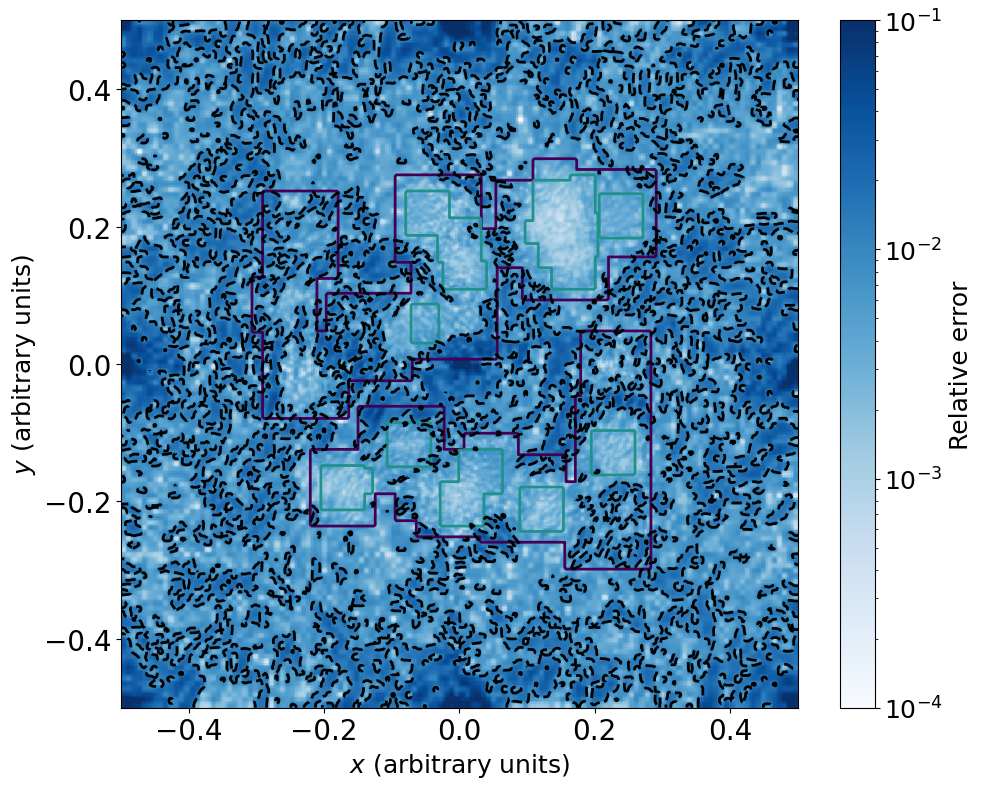

In [417]:
kz=255#300#117
proj = u[:,:,kz].copy()
### gaussian filter in log space 
proj = np.log10(proj)
proj = gaussian_filter(proj, sigma=1)
proj = 10**proj
###

proj2 = ulev[:,:,kz]
absmax=np.abs(proj).max()
projmin,projmax=-absmax,absmax
component =False

xvec=np.linspace(bbox[0]-size/nmax/2**utl/2,bbox[1]+size/nmax/2**utl/2,proj.shape[0])
yvec=np.linspace(bbox[0]-size/nmax/2**utl/2,bbox[1]+size/nmax/2**utl/2,proj.shape[0])

if component:
    ax=masclet.graphics.colormap2d(proj, are_xy_given=True, are_meshgrid=False, x=xvec, y=yvec, 
                                logz=False, cmap='RdBu',cbarmin=projmin,cbarmax=projmax, cbarlabel='Absolute error',
                                xlabel='$x$ (arbitrary units)', ylabel='$y$ (arbitrary units)')
else:
    ax=masclet.graphics.colormap2d(proj, are_xy_given=True, are_meshgrid=False, x=xvec, y=yvec,
                                   logz=True, cmap='Blues', cbarmin=1e-4, cbarmax=1e-1, cbarlabel='Relative error',
                                   xlabel='$x$ (arbitrary units)', ylabel='$y$ (arbitrary units)')
ax.contour(xvec,yvec,proj2.T, levels=[0,1,2], linewidths=2)
ax.contour(xvec, yvec, np.log10(proj.T), levels=[-2], colors='black', linewidths=2)
#ax.contour(xvec, yvec, proj.T, levels=[0.01], colors='black', linewidths=2)

#z1=(boxsize/u.shape[2])*kz
#z2=(boxsize/u.shape[2])*(kz+1)
#select=(z1 < zpart)*(zpart<z2)
#ax.scatter(xpart[select]-boxsize/2,ypart[select]-boxsize/2, s=1, c=hpart[select]**(-1/3))

ax.tick_params(labelsize=20)
#ax.images[0].yaxis.tick_params(labelsize=18)

fig=ax.get_figure()

fig.tight_layout()
#fig.savefig('figures/error_map_2_2.png', dpi=72)

# Test 4: ICM-like velocity field

In [141]:
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)

In [142]:
smooth_velocities = {1: {}, 2: {}, 3: {}}
for irel in range(1,4):
    print(irel)
    with open('test_data/Test 4/realization_{:}/smooth_velocities.dat'.format(irel), 'rb') as f:
        smooth_velocities[irel]=pickle.load(f)[irel]

1
2
3


In [149]:
# Compute errors w/out plotting yet (long)

things_to_plot = {}

#for irel, nx in zip([1,2], [128,256]):
for irel, nx in zip([1,2,3], [128,256,512]):
    things_to_plot[irel] = {}
    
    ### read hpart
    if irel==1:
        filename='particles_2e6.dat'
    elif irel==2:
        filename='particles_16e6.dat'
    elif irel==3:
        filename='particles_128e6.dat'
    else:
        print('Select the particles file!!')
        raise ValueError
    filepath=os.path.join('test_data/particles/', filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            res=pickle.load(f)
            xpart=res['xpart']
            ypart=res['ypart']
            zpart=res['zpart']
            mpart=res['mpart']
            hpart=res['hsml']
            print('Read!',(hpart<hpart_cut).mean())
    else:
        print('Error! File does not exist')
    ### end read hpart

    ### read exact decomposition
    if False:
        with open('test_data/Test 4/realization_{:}/snapdir_000/solution.json'.format(irel), 'r') as f:
            data=json.load(f)
            v_0=data['v_0']
            mode_min=data['modes']['min']
            mode_max=data['modes']['max']
            mode_central=data['modes']['central']
            amplitude_compressive=np.array(data['amplitude_compressive'])
            amplitude_solenoidal=np.array(data['amplitude_solenoidal'])
            random_phases=np.array(data['phases'])
            vxpart=np.array(data['v']['x'])
            vypart=np.array(data['v']['y'])
            vzpart=np.array(data['v']['z'])
            vxpartcomp=np.array(data['vcomp']['x'])
            vypartcomp=np.array(data['vcomp']['y'])
            vzpartcomp=np.array(data['vcomp']['z'])
            vxpartsol=np.array(data['vsol']['x'])
            vypartsol=np.array(data['vsol']['y'])
            vzpartsol=np.array(data['vsol']['z'])
            del data
    ### end read exact decomposition


    results_path='test_data/Test 4/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    elif irel==2:
        linestyle='dashed'
        nbins=200
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)
    print(irel, weight)

    errmed={}
    errlow={}
    errhigh={}

    #### REFERENCE TRUE VELOCITY FOR ERRORS
    kernel='C6'
    ngh=58
    results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')
        res_ypart=f.read_vector('f4')
        res_zpart=f.read_vector('f4')
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

    res_vx_comp_ori = res_vx.copy()
    res_vy_comp_ori = res_vy.copy()
    res_vz_comp_ori = res_vz.copy()
    ####

    for ikernel,kernel in enumerate(kernels):
        things_to_plot[irel][kernel]={}

        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            things_to_plot[irel][kernel][ngh]={}

            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')+size/2
                res_ypart=f.read_vector('f4')+size/2
                res_zpart=f.read_vector('f4')+size/2
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')

                #vxpartcomp = smooth_velocities[irel][kernel][ngh]['vx_conp']
                #vypartcomp = smooth_velocities[irel][kernel][ngh]['vy_conp']
                #vzpartcomp = smooth_velocities[irel][kernel][ngh]['vz_conp']
                vxpartsol = smooth_velocities[irel][kernel][ngh]['vx_sol']
                vypartsol = smooth_velocities[irel][kernel][ngh]['vy_sol']
                vzpartsol = smooth_velocities[irel][kernel][ngh]['vz_sol']
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor) * (hpart<hpart_cut)

            # error wrt the original input velocity and not the smoothed one
            vmod2 = vxpartsol**2 + vypartsol**2 + vzpartsol**2
            epsilon = 0.001*np.sqrt(vmod2.max())
            err=(vxpartsol**4/vmod2**2)*(res_vxrot-vxpartsol)**2/(np.abs(vxpartsol)+epsilon)**2 + \
                (vypartsol**4/vmod2**2)*(res_vyrot-vypartsol)**2/(np.abs(vypartsol)+epsilon)**2 + \
                (vzpartsol**4/vmod2**2)*(res_vzrot-vzpartsol)**2/(np.abs(vzpartsol)+epsilon)**2


            err=np.sqrt(err)
            err=err[select]
            dex_bins=3/nbins
            countsbins=ax.hist(err,bins=np.logspace(-4,-1, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(select.sum())/dex_bins/select.mean(), linestyle=linestyle)
            print(irel, nbins, weight, dex_bins, (countsbins[0]*(np.log10(countsbins[1][1:])-np.log10(countsbins[1][:-1]))).sum())
            things_to_plot[irel][kernel][ngh]['counts']=countsbins[0]
            things_to_plot[irel][kernel][ngh]['bins']=countsbins[1]
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==3:
        #ax.legend(loc='lower right')
        handles, labels = ax.get_legend_handles_labels()

        handles = handles[18:]
        labels = labels[18:]

        #handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        #labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        #handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        #labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        ax.legend(handles, labels, loc='upper left', fontsize=fontsize_smallest)

        

    ax.set_title('Error in the solenoidal velocity', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)
    things_to_plot[irel]['errmed']=errmed
    things_to_plot[irel]['errlow']=errlow
    things_to_plot[irel]['errhigh']=errhigh
    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==3:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

#fig.savefig('figures/test4_solenoidal.pdf', bbox_inches='tight')

Read! 0.0859785
1 5e-07
1 100 5e-07 0.03 0.9899350571735015
W4	 58 	 2.91e-02 	 1.19e-02 	 2.31e-02 	 4.20e-02
1 100 5e-07 0.03 0.988272673055036
W4	 137 	 3.04e-02 	 1.22e-02 	 2.41e-02 	 4.47e-02
1 100 5e-07 0.03 0.9780457799446175
W4	 356 	 3.46e-02 	 1.33e-02 	 2.66e-02 	 5.30e-02
1 100 5e-07 0.03 0.9922024786213025
C4	 58 	 2.72e-02 	 1.10e-02 	 2.15e-02 	 3.93e-02
1 100 5e-07 0.03 0.99323045466629
C4	 137 	 2.67e-02 	 1.08e-02 	 2.11e-02 	 3.85e-02
1 100 5e-07 0.03 0.9922964650025585
C4	 356 	 2.72e-02 	 1.04e-02 	 2.11e-02 	 4.07e-02
1 100 5e-07 0.03 0.9927898935041525
C6	 58 	 2.66e-02 	 1.07e-02 	 2.09e-02 	 3.84e-02
1 100 5e-07 0.03 0.994569760599188
C6	 137 	 2.53e-02 	 1.02e-02 	 1.99e-02 	 3.64e-02
1 100 5e-07 0.03 0.9955037502629196
C6	 356 	 2.45e-02 	 9.31e-03 	 1.89e-02 	 3.59e-02


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


Read! 0.6437993125
2 6.25e-08
2 200 6.25e-08 0.015 0.9999047684791385
W4	 58 	 1.42e-02 	 4.47e-03 	 9.67e-03 	 2.23e-02
2 200 6.25e-08 0.015 0.9998227139752888
W4	 137 	 1.45e-02 	 4.69e-03 	 1.00e-02 	 2.28e-02
2 200 6.25e-08 0.015 0.9989550436985569
W4	 356 	 1.65e-02 	 5.50e-03 	 1.18e-02 	 2.56e-02
2 200 6.25e-08 0.015 1.0002905514853462
C4	 58 	 1.34e-02 	 4.11e-03 	 9.01e-03 	 2.11e-02
2 200 6.25e-08 0.015 1.0006104762393548
C4	 137 	 1.28e-02 	 3.95e-03 	 8.61e-03 	 2.01e-02
2 200 6.25e-08 0.015 1.000817124799584
C4	 356 	 1.28e-02 	 4.04e-03 	 8.78e-03 	 1.99e-02
2 200 6.25e-08 0.015 1.000414267431696
C6	 58 	 1.31e-02 	 3.98e-03 	 8.80e-03 	 2.07e-02
2 200 6.25e-08 0.015 1.000833516186798
C6	 137 	 1.22e-02 	 3.69e-03 	 8.13e-03 	 1.93e-02
2 200 6.25e-08 0.015 1.001252960077462
C6	 356 	 1.16e-02 	 3.52e-03 	 7.74e-03 	 1.81e-02


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


Read! 0.7592524609375
3 7.8125e-09
3 200 7.8125e-09 0.015 1.0039573002333482
W4	 58 	 5.73e-03 	 1.58e-03 	 3.88e-03 	 9.08e-03
3 200 7.8125e-09 0.015 1.0039777349058392
W4	 137 	 5.67e-03 	 1.58e-03 	 3.85e-03 	 9.00e-03
3 200 7.8125e-09 0.015 1.0039649632355323
W4	 356 	 6.20e-03 	 1.77e-03 	 4.23e-03 	 9.88e-03
3 200 7.8125e-09 0.015 1.0039336803993575
C4	 58 	 5.50e-03 	 1.50e-03 	 3.71e-03 	 8.68e-03
3 200 7.8125e-09 0.015 1.003929181875808
C4	 137 	 5.14e-03 	 1.41e-03 	 3.46e-03 	 8.10e-03
3 200 7.8125e-09 0.015 1.0039111360744415
C4	 356 	 5.00e-03 	 1.39e-03 	 3.36e-03 	 7.87e-03
3 200 7.8125e-09 0.015 1.0039193161482989
C6	 58 	 5.43e-03 	 1.48e-03 	 3.66e-03 	 8.57e-03
3 200 7.8125e-09 0.015 1.003889015748301
C6	 137 	 4.99e-03 	 1.36e-03 	 3.35e-03 	 7.85e-03
3 200 7.8125e-09 0.015 1.0038140196729444
C6	 356 	 4.67e-03 	 1.27e-03 	 3.09e-03 	 7.31e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


In [56]:
if False: # write
    with open('test_data/Test 4/analysed_results_solenoidal.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

if True: # read
    with open('test_data/Test 4/analysed_results_solenoidal.dat', 'rb') as f:
        things_to_plot=pickle.load(f)

1 5e-07
2 6.25e-08
3 7.8125e-09


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator


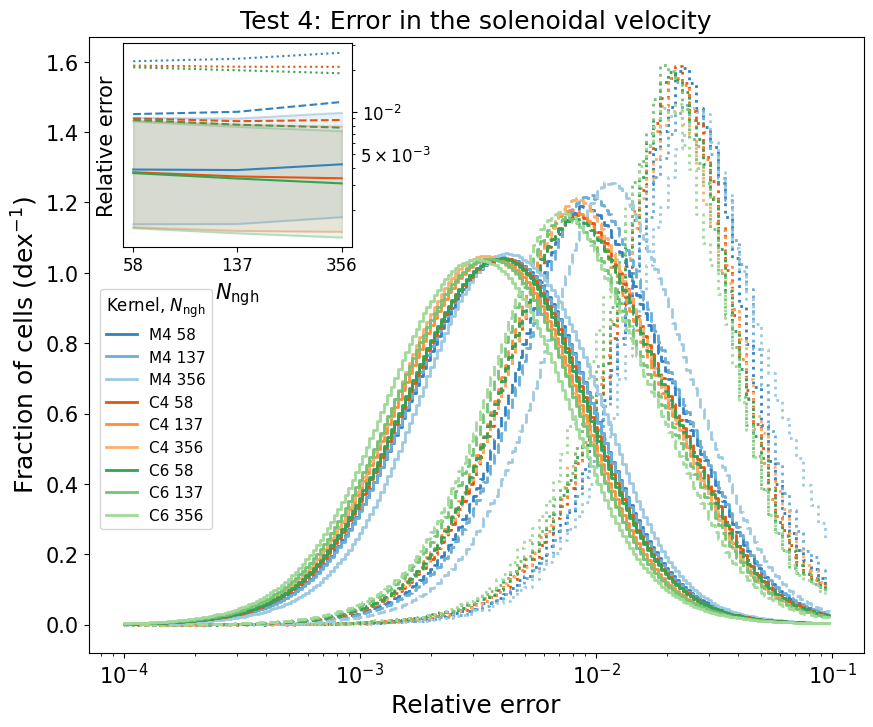

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [57]:
############################
# simplified plotting
############################

fig, ax = plt.subplots(1,1, figsize=(10,8))
hpart_cut = 0.005

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.035, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

#for irel, nx in zip([1,2], [128,256]):
for irel, nx in zip([1,2,3], [128,256,512]):
    
    ### read hpart
    if irel==1:
        filename='particles_2e6.dat'
    elif irel==2:
        filename='particles_16e6.dat'
    elif irel==3:
        filename='particles_128e6.dat'
    else:
        print('Select the particles file!!')
        raise ValueError
    filepath=os.path.join('test_data/particles/', filename)

    results_path='test_data/Test 4/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    elif irel==2:
        linestyle='dashed'
        nbins=200
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)
    print(irel, weight)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11


    for ikernel,kernel in enumerate(kernels):
        for ingh,ngh in enumerate(neighbours):
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            ax.step(things_to_plot[irel][kernel][ngh]['bins'][:-1], things_to_plot[irel][kernel][ngh]['counts'], label=(kernel if kernel!='W4' else 'M4')+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, where='post', linestyle=linestyle)
            #countsbins=ax.hist(err,bins=np.logspace(-4,-1, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
            #    color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(select.sum())/dex_bins/select.mean(), linestyle=linestyle)
            #print(irel, nbins, weight, dex_bins, (countsbins[0]*(np.log10(countsbins[1][1:])-np.log10(countsbins[1][:-1]))).sum())
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            #print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            #errmed[kernel][ngh]=np.median(err)
            #errhigh[kernel][ngh]=np.percentile(err,84)
            #errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==3:
        #ax.legend(loc='lower right')
        handles, labels = ax.get_legend_handles_labels()

        handles = handles[18:]
        labels = labels[18:]

        #handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        #labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        #handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        #labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        legend=ax.legend(handles, labels, loc=[.015,.2], fontsize=fontsize_smallest, title=r'Kernel, $N_\mathrm{ngh}$')
        plt.setp(legend.get_title(),fontsize=fontsize_smallest+1)

        

    ax.set_title('Test 4: Error in the solenoidal velocity', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

    errmed=things_to_plot[irel]['errmed']
    errlow=things_to_plot[irel]['errlow']
    errhigh=things_to_plot[irel]['errhigh']
    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==3:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

#fig.savefig('figures/test4_solenoidal.pdf', bbox_inches='tight')

Read! 0.0859785
1 5e-07
1 100 5e-07 0.03 0.9899350571735015
W4	 58 	 2.91e-02 	 1.19e-02 	 2.31e-02 	 4.20e-02
1 100 5e-07 0.03 0.988272673055036
W4	 137 	 3.04e-02 	 1.22e-02 	 2.41e-02 	 4.47e-02
1 100 5e-07 0.03 0.9780457799446175
W4	 356 	 3.46e-02 	 1.33e-02 	 2.66e-02 	 5.30e-02
1 100 5e-07 0.03 0.9922024786213025
C4	 58 	 2.72e-02 	 1.10e-02 	 2.15e-02 	 3.93e-02
1 100 5e-07 0.03 0.99323045466629
C4	 137 	 2.67e-02 	 1.08e-02 	 2.11e-02 	 3.85e-02
1 100 5e-07 0.03 0.9922964650025585
C4	 356 	 2.72e-02 	 1.04e-02 	 2.11e-02 	 4.07e-02
1 100 5e-07 0.03 0.9927898935041525
C6	 58 	 2.66e-02 	 1.07e-02 	 2.09e-02 	 3.84e-02
1 100 5e-07 0.03 0.994569760599188
C6	 137 	 2.53e-02 	 1.02e-02 	 1.99e-02 	 3.64e-02
1 100 5e-07 0.03 0.9955037502629196
C6	 356 	 2.45e-02 	 9.31e-03 	 1.89e-02 	 3.59e-02
Read! 0.6437993125
2 6.25e-08


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator


2 200 6.25e-08 0.015 0.9999047684791385
W4	 58 	 1.42e-02 	 4.47e-03 	 9.67e-03 	 2.23e-02
2 200 6.25e-08 0.015 0.9998227139752888
W4	 137 	 1.45e-02 	 4.69e-03 	 1.00e-02 	 2.28e-02
2 200 6.25e-08 0.015 0.9989550436985569
W4	 356 	 1.65e-02 	 5.50e-03 	 1.18e-02 	 2.56e-02
2 200 6.25e-08 0.015 1.0002905514853462
C4	 58 	 1.34e-02 	 4.11e-03 	 9.01e-03 	 2.11e-02
2 200 6.25e-08 0.015 1.0006104762393548
C4	 137 	 1.28e-02 	 3.95e-03 	 8.61e-03 	 2.01e-02
2 200 6.25e-08 0.015 1.000817124799584
C4	 356 	 1.28e-02 	 4.04e-03 	 8.78e-03 	 1.99e-02
2 200 6.25e-08 0.015 1.000414267431696
C6	 58 	 1.31e-02 	 3.98e-03 	 8.80e-03 	 2.07e-02
2 200 6.25e-08 0.015 1.000833516186798
C6	 137 	 1.22e-02 	 3.69e-03 	 8.13e-03 	 1.93e-02
2 200 6.25e-08 0.015 1.001252960077462
C6	 356 	 1.16e-02 	 3.52e-03 	 7.74e-03 	 1.81e-02


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator


Read! 0.7592524609375
3 7.8125e-09
3 200 7.8125e-09 0.015 1.0039573002333482
W4	 58 	 5.73e-03 	 1.58e-03 	 3.88e-03 	 9.08e-03
3 200 7.8125e-09 0.015 1.0039777349058392
W4	 137 	 5.67e-03 	 1.58e-03 	 3.85e-03 	 9.00e-03
3 200 7.8125e-09 0.015 1.0039649632355323
W4	 356 	 6.20e-03 	 1.77e-03 	 4.23e-03 	 9.88e-03
3 200 7.8125e-09 0.015 1.0039336803993575
C4	 58 	 5.50e-03 	 1.50e-03 	 3.71e-03 	 8.68e-03
3 200 7.8125e-09 0.015 1.003929181875808
C4	 137 	 5.14e-03 	 1.41e-03 	 3.46e-03 	 8.10e-03
3 200 7.8125e-09 0.015 1.0039111360744415
C4	 356 	 5.00e-03 	 1.39e-03 	 3.36e-03 	 7.87e-03
3 200 7.8125e-09 0.015 1.0039193161482989
C6	 58 	 5.43e-03 	 1.48e-03 	 3.66e-03 	 8.57e-03
3 200 7.8125e-09 0.015 1.003889015748301
C6	 137 	 4.99e-03 	 1.36e-03 	 3.35e-03 	 7.85e-03
3 200 7.8125e-09 0.015 1.0038140196729444
C6	 356 	 4.67e-03 	 1.27e-03 	 3.09e-03 	 7.31e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:220: UserWarning: FixedFormatter should only be used together with FixedLocator


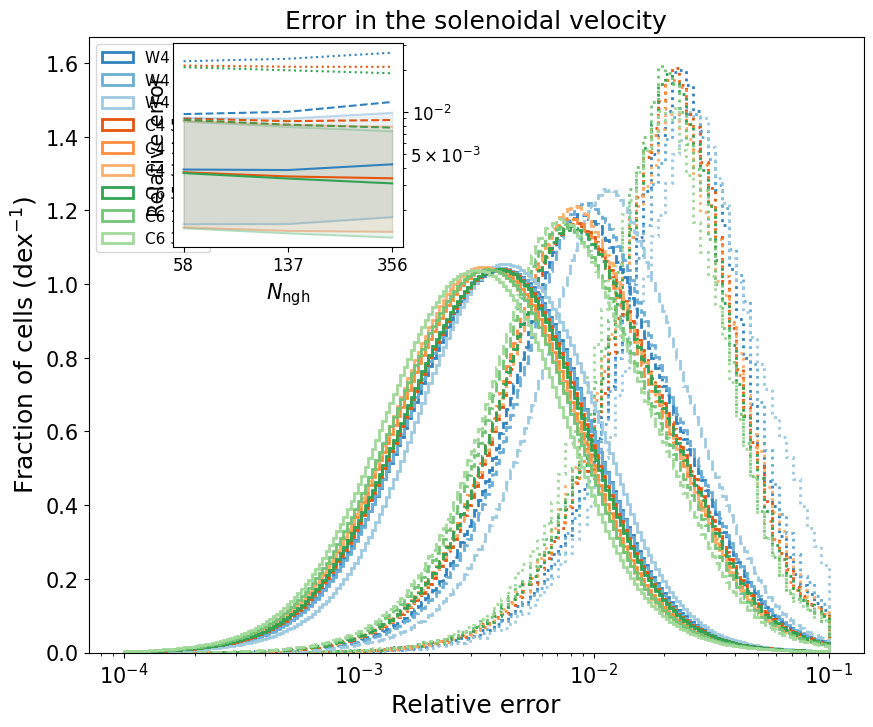

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [148]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
hpart_cut = 0.005

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.1, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

#for irel, nx in zip([1,2], [128,256]):
for irel, nx in zip([1,2,3], [128,256,512]):
    
    ### read hpart
    if irel==1:
        filename='particles_2e6.dat'
    elif irel==2:
        filename='particles_16e6.dat'
    elif irel==3:
        filename='particles_128e6.dat'
    else:
        print('Select the particles file!!')
        raise ValueError
    filepath=os.path.join('test_data/particles/', filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            res=pickle.load(f)
            xpart=res['xpart']
            ypart=res['ypart']
            zpart=res['zpart']
            mpart=res['mpart']
            hpart=res['hsml']
            print('Read!',(hpart<hpart_cut).mean())
    else:
        print('Error! File does not exist')
    ### end read hpart

    ### read exact decomposition
    if False:
        with open('test_data/Test 4/realization_{:}/snapdir_000/solution.json'.format(irel), 'r') as f:
            data=json.load(f)
            v_0=data['v_0']
            mode_min=data['modes']['min']
            mode_max=data['modes']['max']
            mode_central=data['modes']['central']
            amplitude_compressive=np.array(data['amplitude_compressive'])
            amplitude_solenoidal=np.array(data['amplitude_solenoidal'])
            random_phases=np.array(data['phases'])
            vxpart=np.array(data['v']['x'])
            vypart=np.array(data['v']['y'])
            vzpart=np.array(data['v']['z'])
            vxpartcomp=np.array(data['vcomp']['x'])
            vypartcomp=np.array(data['vcomp']['y'])
            vzpartcomp=np.array(data['vcomp']['z'])
            vxpartsol=np.array(data['vsol']['x'])
            vypartsol=np.array(data['vsol']['y'])
            vzpartsol=np.array(data['vsol']['z'])
            del data
    ### end read exact decomposition


    results_path='test_data/Test 4/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    elif irel==2:
        linestyle='dashed'
        nbins=200
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)
    print(irel, weight)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11

    errmed={}
    errlow={}
    errhigh={}

    #### REFERENCE TRUE VELOCITY FOR ERRORS
    kernel='C6'
    ngh=58
    results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')
        res_ypart=f.read_vector('f4')
        res_zpart=f.read_vector('f4')
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

    res_vx_comp_ori = res_vx.copy()
    res_vy_comp_ori = res_vy.copy()
    res_vz_comp_ori = res_vz.copy()
    ####

    for ikernel,kernel in enumerate(kernels):
        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')+size/2
                res_ypart=f.read_vector('f4')+size/2
                res_zpart=f.read_vector('f4')+size/2
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')

                #vxpartcomp = smooth_velocities[irel][kernel][ngh]['vx_conp']
                #vypartcomp = smooth_velocities[irel][kernel][ngh]['vy_conp']
                #vzpartcomp = smooth_velocities[irel][kernel][ngh]['vz_conp']
                vxpartsol = smooth_velocities[irel][kernel][ngh]['vx_sol']
                vypartsol = smooth_velocities[irel][kernel][ngh]['vy_sol']
                vzpartsol = smooth_velocities[irel][kernel][ngh]['vz_sol']
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor) * (hpart<hpart_cut)

            # error wrt the original input velocity and not the smoothed one
            vmod2 = vxpartsol**2 + vypartsol**2 + vzpartsol**2
            epsilon = 0.001*np.sqrt(vmod2.max())
            err=(vxpartsol**4/vmod2**2)*(res_vxrot-vxpartsol)**2/(np.abs(vxpartsol)+epsilon)**2 + \
                (vypartsol**4/vmod2**2)*(res_vyrot-vypartsol)**2/(np.abs(vypartsol)+epsilon)**2 + \
                (vzpartsol**4/vmod2**2)*(res_vzrot-vzpartsol)**2/(np.abs(vzpartsol)+epsilon)**2


            err=np.sqrt(err)
            err=err[select]
            dex_bins=3/nbins
            countsbins=ax.hist(err,bins=np.logspace(-4,-1, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(select.sum())/dex_bins/select.mean(), linestyle=linestyle)
            print(irel, nbins, weight, dex_bins, (countsbins[0]*(np.log10(countsbins[1][1:])-np.log10(countsbins[1][:-1]))).sum())
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==3:
        #ax.legend(loc='lower right')
        handles, labels = ax.get_legend_handles_labels()

        handles = handles[18:]
        labels = labels[18:]

        #handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        #labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        #handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        #labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        ax.legend(handles, labels, loc='upper left', fontsize=fontsize_smallest)

        

    ax.set_title('Error in the solenoidal velocity', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==3:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

#fig.savefig('figures/test4_solenoidal.pdf', bbox_inches='tight')

In [158]:
things_to_plot = {}

#for irel, nx in zip([1,2], [128,256]):
for irel, nx in zip([1,2,3], [128,256,512]):
    things_to_plot[irel] = {}
    
    ### read hpart
    if irel==1:
        filename='particles_2e6.dat'
    elif irel==2:
        filename='particles_16e6.dat'
    elif irel==3:
        filename='particles_128e6.dat'
    else:
        print('Select the particles file!!')
        raise ValueError
    filepath=os.path.join('test_data/particles/', filename)
    if os.path.exists(filepath):
        with open(filepath, 'rb') as f:
            res=pickle.load(f)
            xpart=res['xpart']
            ypart=res['ypart']
            zpart=res['zpart']
            mpart=res['mpart']
            hpart=res['hsml']
            print('Read!',(hpart<hpart_cut).mean())
    else:
        print('Error! File does not exist')
    ### end read hpart

    ### read exact decomposition
    if False:
        with open('test_data/Test 4/realization_{:}/snapdir_000/solution.json'.format(irel), 'r') as f:
            data=json.load(f)
            v_0=data['v_0']
            mode_min=data['modes']['min']
            mode_max=data['modes']['max']
            mode_central=data['modes']['central']
            amplitude_compressive=np.array(data['amplitude_compressive'])
            amplitude_solenoidal=np.array(data['amplitude_solenoidal'])
            random_phases=np.array(data['phases'])
            vxpart=np.array(data['v']['x'])
            vypart=np.array(data['v']['y'])
            vzpart=np.array(data['v']['z'])
            vxpartcomp=np.array(data['vcomp']['x'])
            vypartcomp=np.array(data['vcomp']['y'])
            vzpartcomp=np.array(data['vcomp']['z'])
            vxpartsol=np.array(data['vsol']['x'])
            vypartsol=np.array(data['vsol']['y'])
            vzpartsol=np.array(data['vsol']['z'])
            del data
    ### end read exact decomposition


    results_path='test_data/Test 4/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    elif irel==2:
        linestyle='dashed'
        nbins=200
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)
    print(irel, weight)

    errmed={}
    errlow={}
    errhigh={}

    #### REFERENCE TRUE VELOCITY FOR ERRORS
    kernel='C6'
    ngh=58
    results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')
        res_ypart=f.read_vector('f4')
        res_zpart=f.read_vector('f4')
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

    res_vx_comp_ori = res_vx.copy()
    res_vy_comp_ori = res_vy.copy()
    res_vz_comp_ori = res_vz.copy()
    ####

    for ikernel,kernel in enumerate(kernels):
        things_to_plot[irel][kernel]={}

        errmed[kernel]={}
        errlow[kernel]={}
        errhigh[kernel]={}
        for ingh,ngh in enumerate(neighbours):
            things_to_plot[irel][kernel][ngh]={}

            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
                _=f.read_vector('i4')
                res_xpart=f.read_vector('f4')+size/2
                res_ypart=f.read_vector('f4')+size/2
                res_zpart=f.read_vector('f4')+size/2
                res_vxpartori=f.read_vector('f4')
                res_vypartori=f.read_vector('f4')
                res_vzpartori=f.read_vector('f4')
                _=f.read_vector('f4')
                del _
                res_vx=f.read_vector('f4')
                res_vy=f.read_vector('f4')
                res_vz=f.read_vector('f4')
                res_vxcomp=f.read_vector('f4')
                res_vycomp=f.read_vector('f4')
                res_vzcomp=f.read_vector('f4')
                res_vxrot=f.read_vector('f4')
                res_vyrot=f.read_vector('f4')
                res_vzrot=f.read_vector('f4')

                vxpartcomp = smooth_velocities[irel][kernel][ngh]['vx_conp']
                vypartcomp = smooth_velocities[irel][kernel][ngh]['vy_conp']
                vzpartcomp = smooth_velocities[irel][kernel][ngh]['vz_conp']
                #vxpartsol = smooth_velocities[irel][kernel][ngh]['vx_sol']
                #vypartsol = smooth_velocities[irel][kernel][ngh]['vy_sol']
                #vzpartsol = smooth_velocities[irel][kernel][ngh]['vz_sol']
            
            bor=0.05
            select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor) * (hpart<hpart_cut)

            # error wrt the original input velocity and not the smoothed one
            vmod2 = vxpartcomp**2 + vypartcomp**2 + vzpartcomp**2
            epsilon = 0.001*np.sqrt(vmod2.max())
            err=(vxpartcomp**4/vmod2**2)*(res_vxcomp-vxpartcomp)**2/(np.abs(vxpartcomp)+epsilon)**2 + \
                (vypartcomp**4/vmod2**2)*(res_vycomp-vypartcomp)**2/(np.abs(vypartcomp)+epsilon)**2 + \
                (vzpartcomp**4/vmod2**2)*(res_vzcomp-vzpartcomp)**2/(np.abs(vzpartcomp)+epsilon)**2


            err=np.sqrt(err)
            err=err[select]
            dex_bins=3/nbins
            countsbins=ax.hist(err,bins=np.logspace(-4,-1, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(select.sum())/dex_bins/select.mean(), linestyle=linestyle)
            print(irel, nbins, weight, dex_bins, (countsbins[0]*(np.log10(countsbins[1][1:])-np.log10(countsbins[1][:-1]))).sum())
            things_to_plot[irel][kernel][ngh]['counts']=countsbins[0]
            things_to_plot[irel][kernel][ngh]['bins']=countsbins[1]
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            errmed[kernel][ngh]=np.median(err)
            errhigh[kernel][ngh]=np.percentile(err,84)
            errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==3:
        #ax.legend(loc='lower right')
        handles, labels = ax.get_legend_handles_labels()

        handles = handles[18:]
        labels = labels[18:]

        #handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        #labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        #handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        #labels.append(r'$N_\mathrm{part}= 1.6 \times 10^7$')

        ax.legend(handles, labels, loc='upper left', fontsize=fontsize_smallest)

        

    ax.set_title('Error in the compressive velocity', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)
    things_to_plot[irel]['errmed']=errmed
    things_to_plot[irel]['errlow']=errlow
    things_to_plot[irel]['errhigh']=errhigh
    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==3:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

#fig.savefig('figures/test4_solenoidal.pdf', bbox_inches='tight')

Read! 0.0859785
1 5e-07
1 100 5e-07 0.03 0.9991339742389328
W4	 58 	 2.46e-02 	 1.04e-02 	 1.94e-02 	 3.69e-02
1 100 5e-07 0.03 0.9960794168481126
W4	 137 	 2.75e-02 	 1.19e-02 	 2.17e-02 	 4.15e-02
1 100 5e-07 0.03 0.9763951441238089
W4	 356 	 3.45e-02 	 1.44e-02 	 2.72e-02 	 5.17e-02
1 100 5e-07 0.03 1.000208943474548
C4	 58 	 2.25e-02 	 9.12e-03 	 1.76e-02 	 3.38e-02
1 100 5e-07 0.03 1.0004967767671447
C4	 137 	 2.33e-02 	 9.79e-03 	 1.82e-02 	 3.49e-02
1 100 5e-07 0.03 0.996355501843052
C4	 356 	 2.62e-02 	 1.09e-02 	 2.04e-02 	 3.96e-02
1 100 5e-07 0.03 1.0003440488976036
C6	 58 	 2.18e-02 	 8.64e-03 	 1.70e-02 	 3.28e-02
1 100 5e-07 0.03 1.001289786858992
C6	 137 	 2.17e-02 	 8.94e-03 	 1.69e-02 	 3.26e-02
1 100 5e-07 0.03 1.0006142597437149
C6	 356 	 2.30e-02 	 9.48e-03 	 1.78e-02 	 3.49e-02
Read! 0.6437993125
2 6.25e-08


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


2 200 6.25e-08 0.015 1.0026826207729487
W4	 58 	 1.19e-02 	 3.88e-03 	 8.46e-03 	 1.88e-02
2 200 6.25e-08 0.015 1.002292056945471
W4	 137 	 1.32e-02 	 4.42e-03 	 9.60e-03 	 2.09e-02
2 200 6.25e-08 0.015 1.0004755399981857
W4	 356 	 1.69e-02 	 5.80e-03 	 1.25e-02 	 2.67e-02
2 200 6.25e-08 0.015 1.002918637235268
C4	 58 	 1.09e-02 	 3.48e-03 	 7.65e-03 	 1.72e-02
2 200 6.25e-08 0.015 1.0029138564139972
C4	 137 	 1.12e-02 	 3.63e-03 	 7.95e-03 	 1.77e-02
2 200 6.25e-08 0.015 1.002599688159069
C4	 356 	 1.27e-02 	 4.24e-03 	 9.20e-03 	 2.00e-02
2 200 6.25e-08 0.015 1.0029829344029695
C6	 58 	 1.05e-02 	 3.34e-03 	 7.37e-03 	 1.67e-02
2 200 6.25e-08 0.015 1.003061086195577
C6	 137 	 1.04e-02 	 3.33e-03 	 7.35e-03 	 1.65e-02
2 200 6.25e-08 0.015 1.0030244982776897
C6	 356 	 1.11e-02 	 3.64e-03 	 7.98e-03 	 1.76e-02


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


Read! 0.7592524609375
3 7.8125e-09
3 200 7.8125e-09 0.015 1.004469707919188
W4	 58 	 4.33e-03 	 1.36e-03 	 3.10e-03 	 6.92e-03
3 200 7.8125e-09 0.015 1.0045414154187071
W4	 137 	 4.68e-03 	 1.49e-03 	 3.39e-03 	 7.50e-03
3 200 7.8125e-09 0.015 1.0046024919246423
W4	 356 	 5.87e-03 	 1.88e-03 	 4.31e-03 	 9.43e-03
3 200 7.8125e-09 0.015 1.0043956632557103
C4	 58 	 4.05e-03 	 1.25e-03 	 2.88e-03 	 6.46e-03
3 200 7.8125e-09 0.015 1.004422375178303
C4	 137 	 4.07e-03 	 1.28e-03 	 2.92e-03 	 6.50e-03
3 200 7.8125e-09 0.015 1.0045279095066264
C4	 356 	 4.55e-03 	 1.44e-03 	 3.30e-03 	 7.25e-03
3 200 7.8125e-09 0.015 1.0043605334062924
C6	 58 	 3.96e-03 	 1.22e-03 	 2.81e-03 	 6.30e-03
3 200 7.8125e-09 0.015 1.0043463759839046
C6	 137 	 3.87e-03 	 1.21e-03 	 2.76e-03 	 6.16e-03
3 200 7.8125e-09 0.015 1.00442768033366
C6	 356 	 4.09e-03 	 1.28e-03 	 2.93e-03 	 6.49e-03


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:217: UserWarning: FixedFormatter should only be used together with FixedLocator


In [185]:
if False:
    with open('test_data/Test 4/analysed_results_compressive.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

if True:
    with open('test_data/Test 4/analysed_results_compressive.dat', 'rb') as f:
        things_to_plot=pickle.load(f)

1 5e-07
2 6.25e-08
3 7.8125e-09


/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:119: UserWarning: FixedFormatter should only be used together with FixedLocator


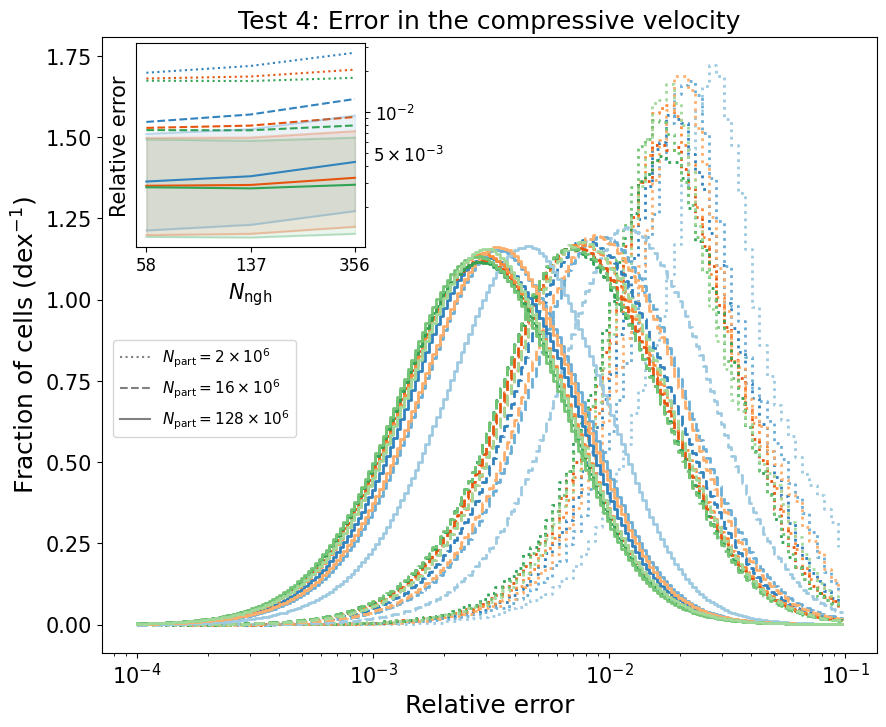

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [186]:
############################
# simplified plotting
############################

fig, ax = plt.subplots(1,1, figsize=(10,8))
hpart_cut = 0.005

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.035, 0.4,0.8,0.6),
            bbox_transform=ax.transAxes)

#for irel, nx in zip([1,2], [128,256]):
for irel, nx in zip([1,2,3], [128,256,512]):
    
    ### read hpart
    if irel==1:
        filename='particles_2e6.dat'
    elif irel==2:
        filename='particles_16e6.dat'
    elif irel==3:
        filename='particles_128e6.dat'
    else:
        print('Select the particles file!!')
        raise ValueError
    filepath=os.path.join('test_data/particles/', filename)

    results_path='test_data/Test 4/realization_{:}'.format(irel)
    it=0
    nmax=nx
    size=1.
    masclet.parameters.write_parameters(nx,nx,nx,10000,9,32,32,32,size,path=results_path)

    kernels = ['W4','C4','C6']
    neighbours = [58, 137, 356]

    if irel==1:
        linestyle='dotted'
        nbins=100
    elif irel==2:
        linestyle='dashed'
        nbins=200
    else:
        linestyle='solid'
        nbins=200
    weight = 1/(nx**3) * (128**3/2e6)
    print(irel, weight)

    plt.figure(figsize=(12,8))

    fontsize_big = 18
    fontsize_small = 15
    fontsize_smaller = 12
    fontsize_smallest = 11


    for ikernel,kernel in enumerate(kernels):
        for ingh,ngh in enumerate(neighbours):
            results_path2 = os.path.join(results_path,'k'+kernel+'_ngh{:}_base{:}_ref5'.format(ngh, nx))
            
            ax.step(things_to_plot[irel][kernel][ngh]['bins'][:-1], things_to_plot[irel][kernel][ngh]['counts'], label=kernel+' {:}'.format(ngh),
                color=cm.tab20c(4*ikernel+ingh), linewidth=2, where='post', linestyle=linestyle)
            #countsbins=ax.hist(err,bins=np.logspace(-4,-1, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
            #    color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(select.sum())/dex_bins/select.mean(), linestyle=linestyle)
            #print(irel, nbins, weight, dex_bins, (countsbins[0]*(np.log10(countsbins[1][1:])-np.log10(countsbins[1][:-1]))).sum())
            
            #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
            #print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
            #errmed[kernel][ngh]=np.median(err)
            #errhigh[kernel][ngh]=np.percentile(err,84)
            #errlow[kernel][ngh]=np.percentile(err,16)
            
    ax.set_xscale('log')
    ax.set_yscale('linear')
    if irel==3:
        #ax.legend(loc='lower right')
        handles, labels = ax.get_legend_handles_labels()

        handles = []
        labels = []

        handles.append(Line2D([0], [0], color='gray', linestyle='dotted'))
        labels.append(r'$N_\mathrm{part}= 2 \times 10^6$')
        handles.append(Line2D([0], [0], color='gray', linestyle='dashed'))
        labels.append(r'$N_\mathrm{part}= 16 \times 10^6$')
        handles.append(Line2D([0], [0], color='gray', linestyle='solid'))
        labels.append(r'$N_\mathrm{part}= 128 \times 10^6$')

        ax.legend(handles, labels, loc=[.015,.35], fontsize=fontsize_smallest)

        

    ax.set_title('Test 4: Error in the compressive velocity', fontsize=fontsize_big)
    ax.tick_params(labelsize=fontsize_small)
    ax.set_xlabel('Relative error', fontsize=fontsize_big)
    ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

    errmed=things_to_plot[irel]['errmed']
    errlow=things_to_plot[irel]['errlow']
    errhigh=things_to_plot[irel]['errhigh']
    for ikernel,kernel in enumerate(errmed.keys()):
        ax2.plot(errmed[kernel].values(),color=cm.tab20c(4*ikernel), label=kernel, linestyle=linestyle)
        if irel==3:
            ax2.plot(errlow[kernel].values(),color=cm.tab20c(4*ikernel), alpha=0.25)
            ax2.plot(errhigh[kernel].values(),color=cm.tab20c(4*ikernel),alpha=0.25)
            ax2.fill_between(np.arange(len(errmed[kernel])),list(errlow[kernel].values()), list(errhigh[kernel].values()), color=cm.tab20c(4*ikernel), alpha=0.1)
    ax2.set_xticks([0,1,2])
    ax2.set_xticklabels(errmed[kernel].keys())
    ax2.set_yscale('log')
    #ax2.set_yticklabels([''  if tt!=5e-4 else '$5 \times 10^{-4}$' for tt in ax2.get_yticks(minor=True)], minor=True)
    #ax2.plot([errmed['W4'][58], errmed['C4'][137], errmed['C6'][356]], color='gray', linestyle='dashed')
    ax2.set_xlabel('$N_\mathrm{ngh}$', fontsize=fontsize_small)
    ax2.set_ylabel('Relative error', fontsize=fontsize_small)

    ax2.tick_params(left=False, labelleft=False, 
                    labelright=True, right=True,
                labelsize=fontsize_smaller, which='both')
    ax2.yaxis.set_label_position("left")
    ax2.set_yticklabels([''  if ti!=5e-3 else r'$5 \times 10^{-3}$' for ti in ax2.get_yticks(minor=True)], 
                        minor=True)

#fig.savefig('figures/test4_compressive.pdf', bbox_inches='tight')

# Convergence

In [2]:
summary = {}

for itest in range(1,5):
    summary[itest] = {}
    for ch in ['compressive', 'solenoidal']:
        filename = 'test_data/Test {:}/analysed_results_{:}'.format(itest, ch)+('_new' if itest!=4 else '')+'.dat'
        with open(filename, 'rb') as f:
            summary[itest][ch]=pickle.load(f)

In [3]:
conta = 0
errmed = {}
for itest in summary.keys():
    errmed[itest]={}
    for ch in summary[itest].keys():
        n_real = len(summary[itest][ch])
        errmed[itest][ch]={}
        for irel in range(1,n_real+1):
            errmed[itest][ch][irel] = summary[itest][ch][irel]['errmed']
        

newdict = {}
for itest in errmed.keys():
    newdict[itest] = {}
    for ch in errmed[itest].keys():
        n_real = len(summary[itest][ch])
        newdict[itest][ch]={}
        for irel in range(1,n_real+1):
            for kernel in errmed[itest][ch][irel].keys():
                if irel==1:
                    newdict[itest][ch][kernel] = {}
                for ngh in errmed[itest][ch][irel][kernel].keys():
                    print(itest, ch, irel, kernel, ngh)
                    if irel == 1:
                        newdict[itest][ch][kernel][ngh] = [errmed[itest][ch][irel][kernel][ngh]]
                    else:
                        newdict[itest][ch][kernel][ngh].append(errmed[itest][ch][irel][kernel][ngh])

1 compressive 1 W4 58
1 compressive 1 W4 137
1 compressive 1 W4 356
1 compressive 1 C4 58
1 compressive 1 C4 137
1 compressive 1 C4 356
1 compressive 1 C6 58
1 compressive 1 C6 137
1 compressive 1 C6 356
1 compressive 2 W4 58
1 compressive 2 W4 137
1 compressive 2 W4 356
1 compressive 2 C4 58
1 compressive 2 C4 137
1 compressive 2 C4 356
1 compressive 2 C6 58
1 compressive 2 C6 137
1 compressive 2 C6 356
1 compressive 3 W4 58
1 compressive 3 W4 137
1 compressive 3 W4 356
1 compressive 3 C4 58
1 compressive 3 C4 137
1 compressive 3 C4 356
1 compressive 3 C6 58
1 compressive 3 C6 137
1 compressive 3 C6 356
1 solenoidal 1 W4 58
1 solenoidal 1 W4 137
1 solenoidal 1 W4 356
1 solenoidal 1 C4 58
1 solenoidal 1 C4 137
1 solenoidal 1 C4 356
1 solenoidal 1 C6 58
1 solenoidal 1 C6 137
1 solenoidal 1 C6 356
1 solenoidal 2 W4 58
1 solenoidal 2 W4 137
1 solenoidal 2 W4 356
1 solenoidal 2 C4 58
1 solenoidal 2 C4 137
1 solenoidal 2 C4 356
1 solenoidal 2 C6 58
1 solenoidal 2 C6 137
1 solenoidal 2 C6 35

1 compressive W4 58 1.0195446701355002
1 compressive W4 137 1.0458614553705272
1 compressive W4 356 1.1251657513710838
1 compressive C4 58 1.013663336428282
1 compressive C4 137 1.0287892965629917
1 compressive C4 356 1.0749043806000431
1 compressive C6 58 1.0111615907975062
1 compressive C6 137 1.0204635734390601
1 compressive C6 356 1.0572294655968961
1 solenoidal W4 58 1.0158792038976612
1 solenoidal W4 137 1.0974570675469613
1 solenoidal W4 356 1.4145633227393812
1 solenoidal C4 58 1.010953061833335
1 solenoidal C4 137 1.0529552667663282
1 solenoidal C4 356 1.26979800126718
1 solenoidal C6 58 1.0140172767237576
1 solenoidal C6 137 1.0377294707027929
1 solenoidal C6 356 1.1948850672780917
In test 1, the convergence order is 1.10
3.25 0.18062126738575332
2 compressive W4 58 1.0407511628827897
2 compressive W4 137 1.096794246410536
2 compressive W4 356 1.3180125205189768
2 compressive C4 58 1.0526103985556856
2 compressive C4 137 1.0663648830410895
2 compressive C4 356 1.2177235033994

/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:117: UserWarning: FixedFormatter should only be used together with FixedLocator
/home/valles/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:118: UserWarning: FixedFormatter should only be used together with FixedLocator


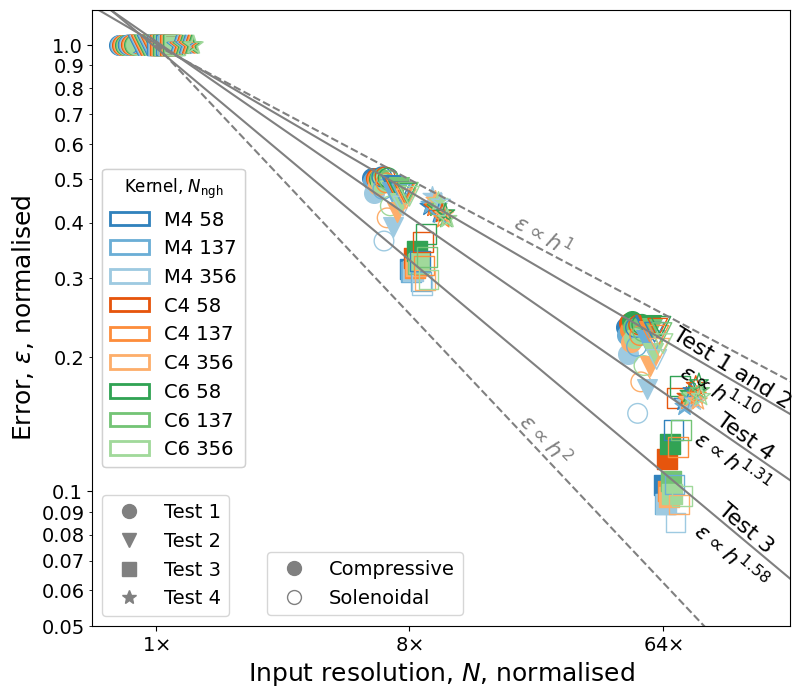

In [13]:
shapes = {1: 'o', 2: 'v', 3: 's', 4: '*'}
filled = {'solenoidal': 'empty', 'compressive': 'full'}
def color_func(kernel, ngh):
    d1 = {'W4': 0, 'C4': 1, 'C6': 2}
    d2 = {58: 0, 137: 1, 356: 2}
    return cm.tab20c(4*d1[kernel]+d2[ngh])
## color=cm.tab20c(4*ikernel+ingh) # write this as dictionaries

fig, ax = plt.subplots(1,1, figsize=(9,8))
ax.set_yscale('log')

conta = 0
for itest in newdict.keys():
    for ch in newdict[itest].keys():
        for kernel in newdict[itest][ch].keys():
            for ngh in newdict[itest][ch][kernel].keys():
                conta += 1
                pass
                
displ = 0.3/conta
mid = displ*conta/2

conta=0
convergence_order = {}
for itest in newdict.keys():
    xxx = []
    yyy = []
    for ch in newdict[itest].keys():
        for kernel in newdict[itest][ch].keys():
            for ngh in newdict[itest][ch][kernel].keys():
                conta+=1
                
                newdict[itest][ch][kernel][ngh] = np.array(newdict[itest][ch][kernel][ngh])

                arr = newdict[itest][ch][kernel][ngh].copy()
                n = len(arr)
                arr = arr/arr[0]

                color = color_func(kernel, ngh)
                edgecolor = color 
                facecolor = color if filled[ch]=='full' else 'none'

                ######### CONVERGENCE ORDER
                slope1 = np.log(arr[1]/arr[0])/np.log(1/2)
                slope2 = np.log(arr[2]/arr[0])/np.log(1/4)
                slope_mean = 0.5*(slope1+slope2)
                print(itest, ch, kernel, ngh, slope_mean)
                #####################################


                ######### BY TEST
                xxx.append(2.**(-np.arange(arr.size)))
                yyy.append(arr)
                #####################################


                off = -mid + conta*displ
                ax.scatter(np.arange(arr.size)+1 +off, arr, marker=shapes[itest], facecolor=facecolor, edgecolor=edgecolor, s=200)
                #ax.plot(np.arange(arr.size)+1, arr, color=color)
    ######### BY TEST
    xxx = np.concatenate(xxx)
    yyy = np.concatenate(yyy)

    fit = np.polyfit(np.log(xxx), np.log(yyy), 1)
    print('In test {:}, the convergence order is {:.2f}'.format(itest, fit[0]))

    if itest==2:
        print('Skipping drawing test 2 bc it is the same as test 1')
        continue

    rotn = np.arctan(-fit[0]*np.log(2))*180/np.pi * 0.85
    #rotn = 45.
    xtext = 3.3 if itest != 1 else 3.25 #1.5 + 0.5*(itest-1)
    ytext = np.exp(fit[1] - fit[0]*np.log(2)*(xtext-1))
    print(xtext, ytext)
    ax.text(xtext, ytext, 'Test 1 and 2' if itest==1 else 'Test {:}'.format(itest), 
        ha='center', va='bottom', fontsize=16,
        rotation=rotn, rotation_mode='anchor', transform_rotates_text=False)
    ax.text(xtext, ytext - 0.004, r'$\varepsilon \propto h^{{{:.2f}}}$'.format(fit[0]), 
        ha='center', va='top', fontsize=16,
        rotation=rotn, rotation_mode='anchor', transform_rotates_text=False)

    xplot = np.linspace(0.5, 3.5, 100)
    xplot_2 = (2.**(-xplot+1))
    yplot = np.exp(fit[1]) * xplot_2**fit[0]
    plt.plot(xplot + displ*conta/len(newdict)*(itest-len(newdict)/2)*0, yplot, color='gray')
    #####################################

    

xxx = np.arange(1,5)
ax.plot(xxx, 1/2**(xxx-1), color='gray', linestyle='dashed')
if True:
    rotn = np.arctan(-1*np.log(2))*180/np.pi * 0.85
    #rotn = 45.
    xtext = 2.5
    ytext = np.exp(0 - 1*np.log(2)*(xtext-1))
    ax.text(xtext, ytext, r'$\varepsilon \propto h^1$',
        ha='center', va='bottom', fontsize=16, color='gray',
        rotation=rotn, rotation_mode='anchor', transform_rotates_text=False)
ax.plot(xxx, 1/(2**(xxx-1))**2, color='gray', linestyle='dashed')
if True:
    rotn = np.arctan(-2*np.log(2))*180/np.pi * 0.85
    #rotn = 45.
    xtext = 2.5
    ytext = np.exp(0 - 2*np.log(2)*(xtext-1))
    ax.text(xtext, ytext, r'$\varepsilon \propto h^2$',
        ha='center', va='bottom', fontsize=16, color='gray',
        rotation=rotn, rotation_mode='anchor', transform_rotates_text=False)
#ax.plot(xxx, 1/(2**(xxx-1))**(1.3), color='gray', linestyle='dashed')

ax.set_xlim([0.75, 3.5])
ax.set_ylim([.05, 1.2])
ax.set_xticks([1,2,3])
ax.set_xticklabels([r'1$\times$', r'8$\times$', r'64$\times$'])
ax.set_yticklabels(['{:.1f}'.format(ti) if ti>=0.1 else '{:.2f}'.format(ti)
                    for ti in ax.get_yticks(minor=True)], minor=True)
ax.set_yticklabels(['{:.1f}'.format(ti) for ti in ax.get_yticks(minor=False)], minor=False)

ax.set_xlabel('Input resolution, $N$, normalised', fontsize=18)
ax.set_ylabel('Error, $\epsilon$, normalised', fontsize=18)
ax.tick_params(labelsize=14, which='both')

list_mak = [Line2D([], [], color='gray', marker=v, linestyle='None',
                          markersize=10) for v in shapes.values()]
list_lab = ['Test {:}'.format(i) for i in shapes.keys()]
leg = plt.legend(list_mak, list_lab, loc='lower left', fontsize=14)
ax.add_artist(leg)

list_mak = [Line2D([], [], color='gray', marker='o', linestyle='None',
                          markersize=10, fillstyle='full'),
            Line2D([], [], color='gray', marker='o', linestyle='None',
                          markersize=10, fillstyle='none')]
list_lab = ['Compressive', 'Solenoidal']
leg = plt.legend(list_mak, list_lab, fontsize=14, loc=(0.25, 0.017))
ax.add_artist(leg)

#### run one of the tests to get the legend stuff
print(labels)
leg = ax.legend(handles, labels, loc='center left', fontsize=14, title='Kernel, $N_\mathrm{ngh}$')
plt.setp(leg.get_title(),fontsize=fontsize_smallest+1)
ax.add_artist(leg)

#fig.savefig('figures/convergence.pdf', bbox_inches='tight')


# Scalability

## Scaling properties (computational)

In [31]:
with open('test_data/Scalability/results_1_Npart.json', 'r') as f:
    test1 = json.load(f)

x = [int(a)**3 for a in test1['walltime'].keys()]
y = [min(a) for a in test1['walltime'].values()]
erry = [np.std(a) for a in test1['walltime'].values()]

Delta_0 = 9.18 +/- 7.47
Delta_1 = 12.65 +/- 4.60
alpha = 0.989 +/- 0.098
Delta_ser = 762.36 +/- 101.60
Delta_par = 27585.41 +/- 213.39
alpha = 0.931 +/- 0.016
Delta_ser = 762.36 +/- 101.60
Delta_par = 27585.41 +/- 213.39
alpha = 0.931 +/- 0.016


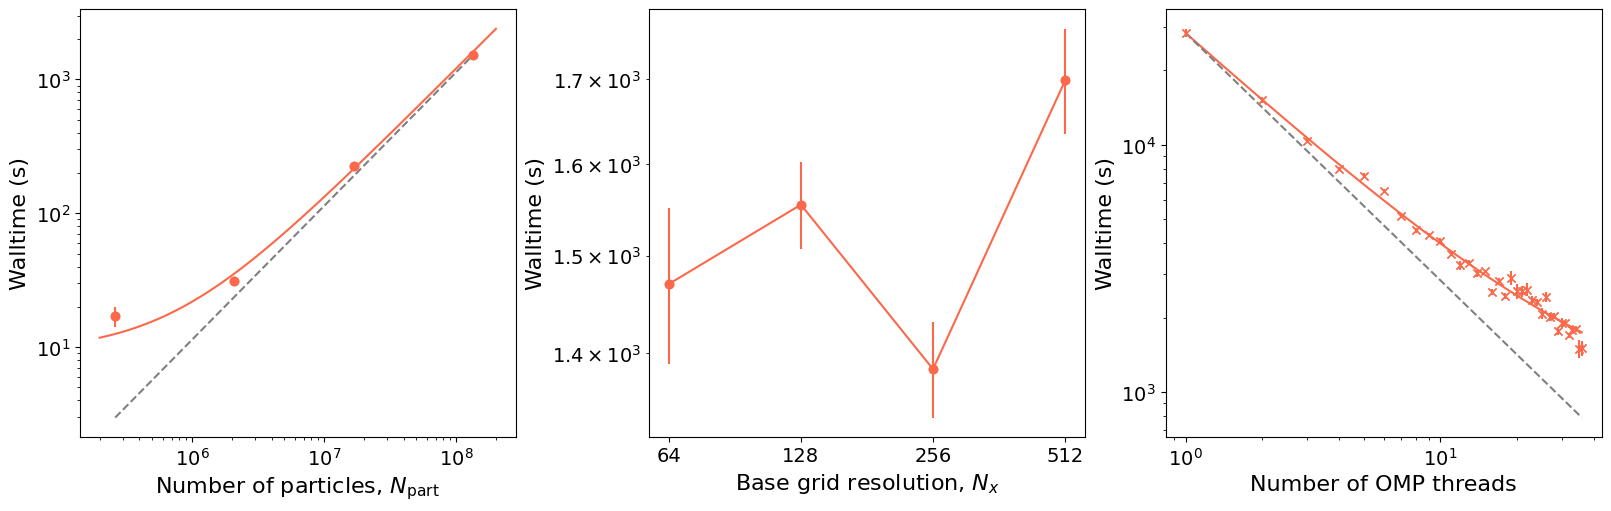

In [2]:
#fig, ax = plt.subplots(1,3, figsize=(15,5))

fig = plt.figure(figsize=(16,5), constrained_layout=True)
gs = fig.add_gridspec(1, 3)
ax = [fig.add_subplot(gs[0, 0]), fig.add_subplot(gs[0, 1]), fig.add_subplot(gs[0, 2])]
#for axi in ax:
#    axi.set_aspect(1)

fontsize_small = 14
fontsize_big = 16

#fig.subplots_adjust(wspace=0.5)

#### Test 1
with open('test_data/Scalability/results_1_Npart.json', 'r') as f:
    test1 = json.load(f)

x = [int(a)**3 for a in test1['walltime'].keys()]
y = [min(a) for a in test1['walltime'].values()]
erry = [np.std(a) for a in test1['walltime'].values()]

ax[0].plot(x, y, linestyle='none', marker='o', color=cm.Reds(0.5))
ax[0].errorbar(x, y, yerr=erry, linestyle='none', marker='o', color=cm.Reds(0.5))
ax[0].set_xscale('log')
ax[0].set_yscale('log')

ax[0].plot(x, y[-1]*(np.array(x)/x[-1])**1, linestyle='dashed', color='gray', label='$\propto N_\mathrm{part}$')

ax[0].set_xlabel('Number of particles, $N_\mathrm{part}$', fontsize=fontsize_big)
ax[0].set_ylabel('Walltime (s)', fontsize=fontsize_big)
ax[0].tick_params(labelsize=fontsize_small, which='both')

if False:
    def f(x, Delta_0, alpha):
        return np.log10(Delta_0) + alpha*np.log10(x/1e6)
    pars, cov = curve_fit(f, x, np.log10(y), sigma=np.array(erry)/np.array(y), p0=[50, 1])
    err = np.sqrt(np.diag(cov))
    print('Delta_0 = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
    print('alpha = {:.3f} +/- {:.3f}'.format(pars[1], err[1]))
if True:
    def f(x, Delta_0, Delta_1, alpha):
        return np.log10(Delta_0 + Delta_1 * (x/1e6)**alpha )
    pars, cov = curve_fit(f, x, np.log10(y), sigma=np.array(erry)/np.array(y), p0=[10, 20, 1])
    err = np.sqrt(np.diag(cov))
    print('Delta_0 = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
    print('Delta_1 = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))
    print('alpha = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))

xplot = 2*np.logspace(5, 8, 100)
yplot = 10**f(xplot, *pars)
ax[0].plot(xplot, yplot, linestyle='solid', color=cm.Reds(0.5), label='Fit')

#### Test 2
with open('test_data/Scalability/results_2_Nx.json', 'r') as f:
    test2 = json.load(f)

x = [int(a) for a in test2['walltime'].keys()]
y = [min(a) for a in test2['walltime'].values()]
erry = [np.std(a) for a in test2['walltime'].values()]

ax[1].plot(x, y, linestyle='solid', marker='o', color=cm.Reds(0.5))
ax[1].errorbar(x, y, yerr=erry, linestyle='none', marker='o', color=cm.Reds(0.5))
ax[1].set_xscale('log')
ax[1].set_yscale('log')

ax[1].set_xlabel('Base grid resolution, $N_x$', fontsize=fontsize_big)
ax[1].set_ylabel('Walltime (s)', fontsize=fontsize_big)
ax[1].tick_params(labelsize=fontsize_small, which='both')
ax[1].set_xticks([], minor=True)
ax[1].set_xticks([64,128,256,512])
ax[1].set_xticklabels([64,128,256,512])

#### Test 3
with open('test_data/Scalability/results_3_Ncores.json', 'r') as f:
    test3 = json.load(f)

x = [int(a) for a in test3['walltime'].keys()]
y = [np.min(a) for a in test3['walltime'].values()]
erry = [np.std(a) for a in test3['walltime'].values()]

ax[2].plot(x, y, linestyle='none', marker='x', color=cm.Reds(0.5))
ax[2].errorbar(x, y, yerr=erry, linestyle='none', marker='x', color=cm.Reds(0.5))
ax[2].set_xscale('log')
ax[2].set_yscale('log')

ax[2].set_xlabel('Number of OMP threads', fontsize=fontsize_big)
ax[2].set_ylabel('Walltime (s)', fontsize=fontsize_big)
ax[2].tick_params(labelsize=fontsize_small, which='both')

########### this is the one I used
def f(x, Delta_ser, Delta_par, alpha):
    return Delta_ser + Delta_par / x**alpha
pars, cov = curve_fit(f, x, y, p0=[1000, 20000, 1])
err = np.sqrt(np.diag(cov))
print('Delta_ser = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
print('Delta_par = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))
print('alpha = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))
################

##### tests
if True: # linear scale fit
    if False: # with penalization numa
        def f(x, Delta_ser, Delta_par, alpha, pen_numa):
            return Delta_ser + Delta_par / x**alpha * (1 + pen_numa*(x>18))
        pars, cov = curve_fit(f, x, y, p0=[1000, 20000, 2, 1], sigma=erry)
        err = np.sqrt(np.diag(cov))
        print('Delta_ser = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
        print('Delta_par = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))
        print('alpha = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))
        print('pen_numa = {:.3f} +/- {:.3f}'.format(pars[3], err[3]))
    else: # without penalization numa
        def f(x, Delta_ser, Delta_par, alpha):
            return Delta_ser + Delta_par / x**alpha
        pars, cov = curve_fit(f, x, y, p0=[1000, 20000, 1], maxfev=10000)
        err = np.sqrt(np.diag(cov))
        print('Delta_ser = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
        print('Delta_par = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))
        print('alpha = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))
else: # log scale fit
    if True: # with penalization numa 
        if False: # variable alpha
            def f(x, Delta_ser, quot, alpha, pen_numa):
                return np.log10(Delta_ser) + np.log10(1 + quot / x**alpha * (1 + pen_numa*(x>18)))
            pars, cov = curve_fit(f, x, np.log10(y), p0=[1000, 20, 1, .1], maxfev=10000)
            err = np.sqrt(np.diag(cov))
            print('Delta_ser = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
            print('quot = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))
            print('alpha = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))
            print('pen_numa = {:.3f} +/- {:.3f}'.format(pars[3], err[3]))
        else: # fix alpha 
            def f(x, Delta_ser, quot, pen_numa):
                return np.log10(Delta_ser) + np.log10(1 + quot / x**1 * (1 + pen_numa*(x>18)))
            y = np.array(y)
            erry = np.array(erry)
            pars, cov = curve_fit(f, x, np.log10(y), p0=[1000, 20, .1], maxfev=10000)
            err = np.sqrt(np.diag(cov))
            print('Delta_ser = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
            print('quot = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))
            print('pen_numa = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))
    else: # without penalization numa
        if False: # variable alpha
            def f(x, Delta_ser, quot, alpha):
                return np.log10(Delta_ser) + np.log10(1 + quot / x**alpha)
            pars, cov = curve_fit(f, x, np.log10(y), p0=[1000, 20, 1], maxfev=10000)
            err = np.sqrt(np.diag(cov))
            print('Delta_ser = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
            print('quot = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))
            print('alpha = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))
        else: # fix alpha
            def f(x, Delta_ser, quot):
                return np.log10(Delta_ser) + np.log10(1 + quot / x**1)
            pars, cov = curve_fit(f, x, np.log10(y), p0=[1000, 20], maxfev=10000)
            err = np.sqrt(np.diag(cov))
            print('Delta_ser = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
            print('quot = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))

xplot = np.linspace(1, 36, 100)
yplot = f(xplot, *pars)
#yplot = 10**yplot
ax[2].plot(xplot, yplot, linestyle='solid', color=cm.Reds(0.5), label='Fit')

ax[2].plot(xplot, yplot[0]*(xplot/xplot[0])**(-1), linestyle='dashed', color='gray', label=r'$\propto N_\mathrm{cores}^{-1}$')
#fig.tight_layout()

#fig.savefig('figures/scalability.pdf', bbox_inches='tight')

Delta_ser = 1100.56 +/- 71.99
Delta_par = 27708.06 +/- 276.03
pena_numa = 0.047 +/- 0.120


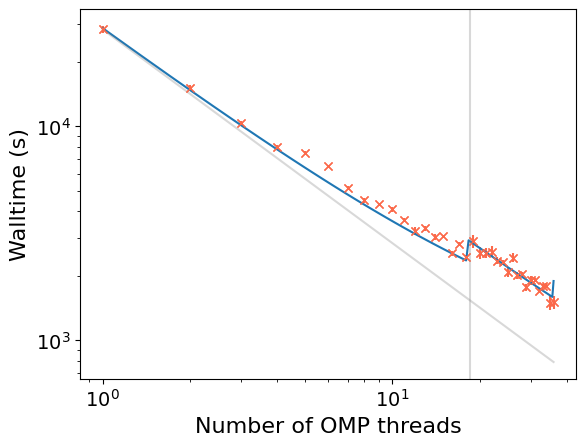

In [50]:
#### Test 3
fig, ax = plt.subplots(1,1)

with open('test_data/Scalability/results_3_Ncores.json', 'r') as f:
    test3 = json.load(f)

x = [int(a) for a in test3['walltime'].keys()]
y = [np.min(a) for a in test3['walltime'].values()]
erry = [np.std(a) for a in test3['walltime'].values()]

ax.plot(x, y, linestyle='none', marker='x', color=cm.Reds(0.5))
ax.errorbar(x, y, yerr=erry, linestyle='none', marker='x', color=cm.Reds(0.5))
ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel('Number of OMP threads', fontsize=fontsize_big)
ax.set_ylabel('Walltime (s)', fontsize=fontsize_big)
ax.tick_params(labelsize=fontsize_small, which='both')

########### this is the one I used
def f(x, Delta_ser, Delta_par, pena_numa):
    alpha=1
    return Delta_ser + Delta_par / x**alpha * (1 +  pena_numa*(x/18-.000001).astype('i4')*(1-np.mod(x,18)/18))
pars, cov = curve_fit(f, x, y, p0=[1000, 20000, .2])
err = np.sqrt(np.diag(cov))
print('Delta_ser = {:.2f} +/- {:.2f}'.format(pars[0], err[0]))
print('Delta_par = {:.2f} +/- {:.2f}'.format(pars[1], err[1]))
#print('alpha = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))
print('pena_numa = {:.3f} +/- {:.3f}'.format(pars[2], err[2]))
################

xxx = np.linspace(1,36,100)
ax.plot(xxx, f(xxx, 800, 28e3,.4))

ax.axvline(18.5, c='gray', alpha=.3)
ax.plot(xxx, max(y)/xxx, c='gray', alpha=.3)

## Error when varying $N_x$

In [10]:
smooth_velocities = {}
for irel in range(0,3+1):
    print(irel)
    with open('test_data/Test 4/realization_{:}/smooth_velocities.dat'.format(irel), 'rb') as f:
        scr = pickle.load(f) 
        if irel==3:
            scr = scr[3]
        smooth_velocities[irel]=scr 
        del scr

0
1
2
3


In [14]:
boxsize=1.
nbins = 200

64
128
256
512


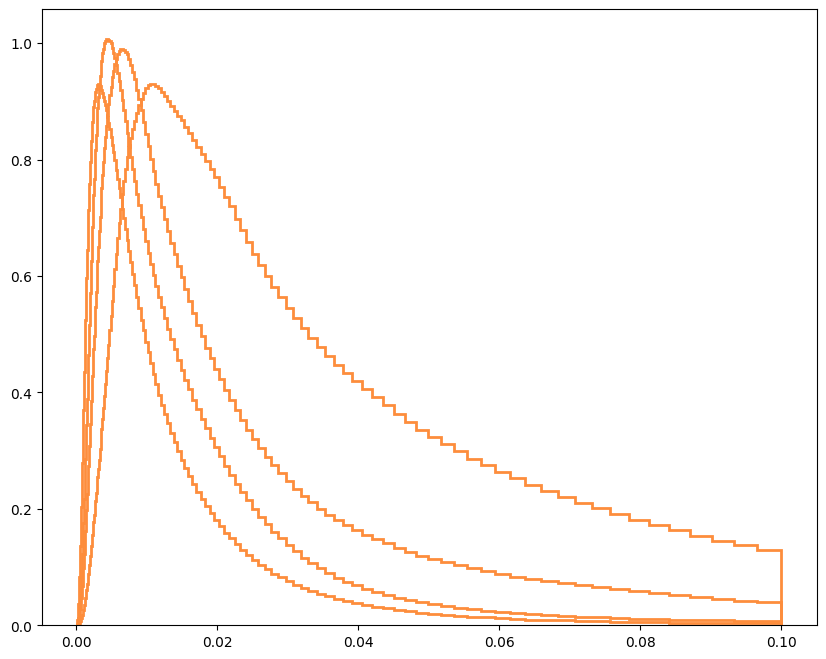

In [27]:
things_to_plot = {}
fig, ax = plt.subplots(1,1, figsize=(10,8))
for Nx in [64, 128, 256, 512]:
    print(Nx)
    with FF('test_data/Scalability/velocity-particles_Nx{:}'.format(Nx), 'r') as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')+size/2
        res_ypart=f.read_vector('f4')+size/2
        res_zpart=f.read_vector('f4')+size/2
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

    vxpart = np.sin(2*np.pi*res_xpart) + np.sin(4*np.pi*res_ypart) + np.sin(6*np.pi*res_zpart)
    vypart = np.sin(6*np.pi*res_xpart) + np.sin(2*np.pi*res_ypart) + np.sin(4*np.pi*res_zpart)
    vzpart = np.sin(4*np.pi*res_xpart) + np.sin(6*np.pi*res_ypart) + np.sin(2*np.pi*res_zpart)

    #vxpartcomp = np.sin(2*np.pi*res_xpart)
    #vxpartsol = res_vxpartori - vxpartcomp
    #vypartcomp = np.sin(2*np.pi*res_ypart)
    #vypartsol = res_vypartori - vypartcomp
    #vzpartcomp = np.sin(2*np.pi*res_zpart)
    #vzpartsol = res_vzpartori - vzpartcomp
    kernel = 'C4'
    ngh = 137
    irel = 3

    vxpartcomp = smooth_velocities[irel][kernel][ngh]['vx_conp']
    vypartcomp = smooth_velocities[irel][kernel][ngh]['vy_conp']
    vzpartcomp = smooth_velocities[irel][kernel][ngh]['vz_conp']
    vxpartsol = smooth_velocities[irel][kernel][ngh]['vx_sol']
    vypartsol = smooth_velocities[irel][kernel][ngh]['vy_sol']
    vzpartsol = smooth_velocities[irel][kernel][ngh]['vz_sol']

    # error wrt the original input velocity and not the smoothed one
    vmod2 = vxpartcomp**2 + vypartcomp**2 + vzpartcomp**2
    epsilon = 0.001*np.sqrt(vmod2.max())
    err=(vxpartcomp**4/vmod2**2)*(res_vxcomp-vxpartcomp)**2/(np.abs(vxpartcomp)+epsilon)**2 + \
        (vypartcomp**4/vmod2**2)*(res_vycomp-vypartcomp)**2/(np.abs(vypartcomp)+epsilon)**2 + \
        (vzpartcomp**4/vmod2**2)*(res_vzcomp-vzpartcomp)**2/(np.abs(vzpartcomp)+epsilon)**2

    bor=0.05
    select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)

    err=np.sqrt(err)
    err=err[select]
    dex_bins=3./nbins
    ikernel=1 
    ingh=1
    weight=1/128e6
    linestyle='solid'
    histcounts=ax.hist(err,bins=np.logspace(-4,-1, nbins), histtype='step', label=kernel+' {:}'.format(ngh),
        color=cm.tab20c(4*ikernel+ingh), linewidth=2, weights=weight*np.ones(err.size)/dex_bins, linestyle=linestyle)
    things_to_plot[Nx] = histcounts

In [20]:
if False:
    with open('test_data/Scalability/analysed_results_Nx.dat', 'wb') as f:
        pickle.dump(things_to_plot, f)

In [21]:
with open('test_data/Scalability/analysed_results_Nx.dat', 'rb') as f:
    things_to_plot=pickle.load(f)

64
128
256
512


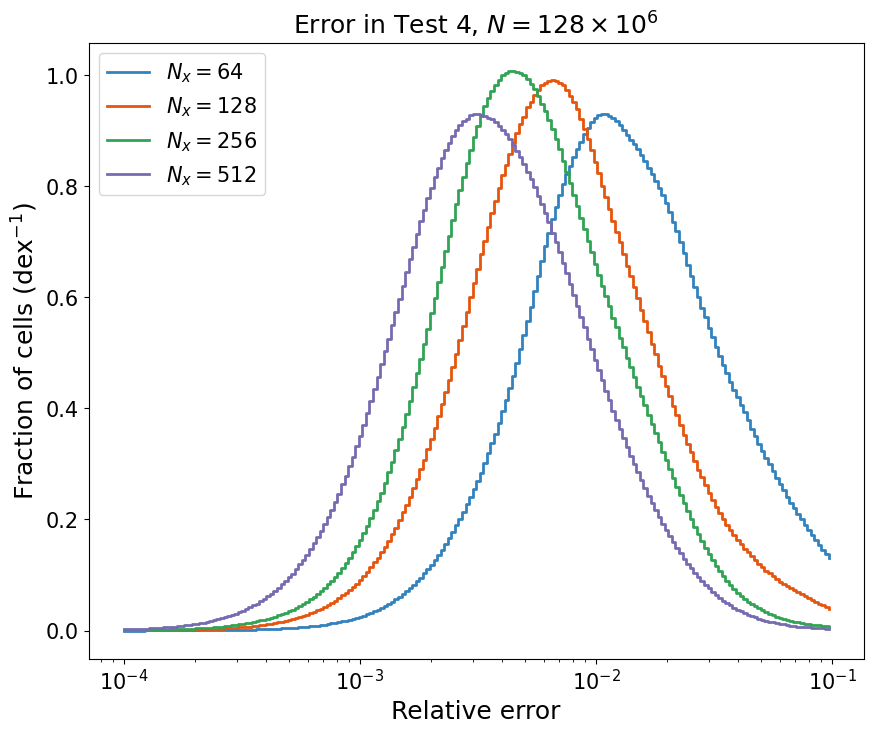

In [30]:
fig, ax = plt.subplots(1,1, figsize=(10,8))

fontsize_big = 18
fontsize_small = 15
fontsize_smaller = 12
fontsize_smallest = 11

for iNx,Nx in enumerate([64, 128, 256, 512]):
    print(Nx)
    ax.step(things_to_plot[Nx][1][:-1], things_to_plot[Nx][0], label='$N_x={:}$'.format(Nx),
            color=cm.tab20c(4*iNx), linewidth=2, where='post', linestyle=linestyle)

ax.set_title(r'Error in Test 4, $N=128 \times 10^6$', fontsize=fontsize_big)
ax.tick_params(labelsize=fontsize_small)
ax.set_xlabel('Relative error', fontsize=fontsize_big)
ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

ax.set_xscale('log')
ax.set_yscale('linear')
ax.legend(fontsize=fontsize_small, loc='upper left')

fig.savefig('figures/scalability_Nx.pdf', bbox_inches='tight')

# Appendix: periodicity test

In [2]:
%pwd

'/scratch/valles/Projects/DIANOGA_vortex/vortex-SPH/test'

In [11]:
with open('test_data/Test 3/smooth_velocities.dat', 'rb') as f:
    smooth_velocities=pickle.load(f)

Warning!!! The file already exists. Reading it
File read!
1 100 5e-07 0.03 0.9252175206662356
C4	 137 	 4.27e-03 	 1.73e-03 	 3.25e-03 	 5.99e-03
1 100 5.361884294826426e-07 0.03 0.9257005242530202
C4	 137 	 4.80e-03 	 2.30e-03 	 3.74e-03 	 6.54e-03
1 100 5.693480111250602e-07 0.03 0.9251853204271167
C4	 137 	 4.32e-03 	 1.78e-03 	 3.33e-03 	 6.02e-03
1 100 5.981727020298393e-07 0.03 0.9252497209053545
C4	 137 	 4.33e-03 	 1.66e-03 	 3.29e-03 	 6.12e-03
1 100 6.221582920012842e-07 0.03 0.9255958734758836
C4	 137 	 4.69e-03 	 1.90e-03 	 3.42e-03 	 6.61e-03
aaaaa
missing select
found one
1 100 7.189827257210319e-07 0.03 0.9256200236552229
C4	 137 	 6.19e-03 	 2.39e-03 	 5.24e-03 	 9.07e-03
1 100 1.4330486820967795e-06 0.03 0.9256119735954429
C4	 137 	 6.39e-03 	 3.72e-03 	 5.63e-03 	 8.36e-03
1 100 3.6210105516247473e-06 0.03 0.9251128698890976
C4	 137 	 9.27e-03 	 3.67e-03 	 7.08e-03 	 1.20e-02
1 100 8.694064562123438e-06 0.03 0.9226576016562702
C4	 137 	 1.66e-02 	 6.97e-03 	 1.38e-02 

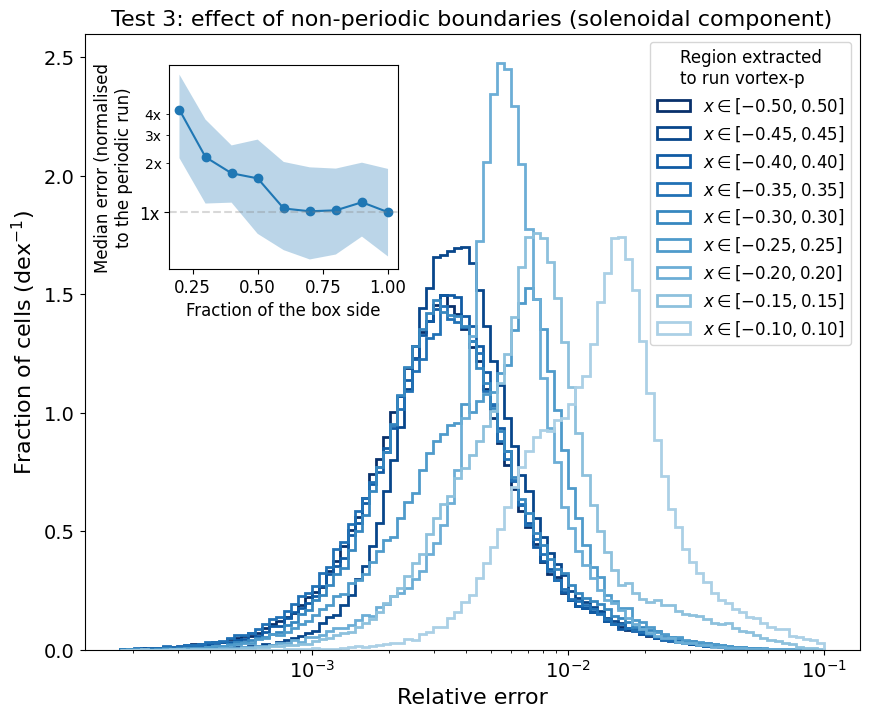

In [96]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
fontsize_small = 14
fontsize_big = 16
fontsize_smaller = 12

path = 'test_data/periodicity/src'
it=0
size0=1.

irel=1
kernel = 'C4'
ngh=137

filepath='test_data/particles/particles_2e6.dat'
if os.path.exists(filepath):
    print('Warning!!! The file already exists. Reading it')
    with open(filepath, 'rb') as f:
        res=pickle.load(f)
        xpart=res['xpart'].astype('f4')
        ypart=res['ypart'].astype('f4')
        zpart=res['zpart'].astype('f4')
        mpart=res['mpart']
        hpart=res['hsml']
        
    print('File read!')

fracs = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
errmed = {}
errlow = {}
errhigh = {}
for ifrac, frac_length in enumerate(fracs):
    size = size0#*frac_length
    ### Error in the solenoidal velocity as in Test 3 
    results_path2 = os.path.join(path, 'output_files_{:.2f}'.format(frac_length))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')+size/2
        res_ypart=f.read_vector('f4')+size/2
        res_zpart=f.read_vector('f4')+size/2
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

        vxpart = np.sin(2*np.pi*res_xpart) + np.sin(4*np.pi*res_ypart) + np.sin(6*np.pi*res_zpart)
        vypart = np.sin(6*np.pi*res_xpart) + np.sin(2*np.pi*res_ypart) + np.sin(4*np.pi*res_zpart)
        vzpart = np.sin(4*np.pi*res_xpart) + np.sin(6*np.pi*res_ypart) + np.sin(2*np.pi*res_zpart)

        #vxpartcomp = np.sin(2*np.pi*res_xpart)
        #vxpartsol = res_vxpartori - vxpartcomp
        #vypartcomp = np.sin(2*np.pi*res_ypart)
        #vypartsol = res_vypartori - vypartcomp
        #vzpartcomp = np.sin(2*np.pi*res_zpart)
        #vzpartsol = res_vzpartori - vzpartcomp
        bor = frac_length/2
        select = (np.abs(xpart-size0/2)<bor) * (np.abs(ypart-size0/2)<bor) * (np.abs(zpart-size0/2)<bor)
        if select.sum() != res_vx.size:
            print('aaaaa')
            if select.sum() > res_vx.size:
                print('extra select')
            else:
                print('missing select')
                i=0
                for j in range(select.size):
                    if select[j]:
                        i+=1 
                    else:
                        dista=max(np.abs(res_xpart[i]-xpart[j]), np.abs(res_ypart[i]-ypart[j]), np.abs(res_zpart[i]-zpart[j]))
                        if dista<1e-5:
                            select[j]=True
                            print('found one')
        #tol=1e-7
        #select = (np.abs(np.abs(xpart-size0/2)-bor) < tol) * (np.abs(np.abs(ypart-size0/2)-bor) < tol) * (np.abs(np.abs(zpart-size0/2)-bor) < tol)

        vxpartcomp = smooth_velocities[irel][kernel][ngh]['vx_conp'][select]
        vypartcomp = smooth_velocities[irel][kernel][ngh]['vy_conp'][select]
        vzpartcomp = smooth_velocities[irel][kernel][ngh]['vz_conp'][select]
        vxpartsol = smooth_velocities[irel][kernel][ngh]['vx_sol'][select]
        vypartsol = smooth_velocities[irel][kernel][ngh]['vy_sol'][select]
        vzpartsol = smooth_velocities[irel][kernel][ngh]['vz_sol'][select]

    #bor=0.05
    #select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)
    region = 0.1
    select = (np.abs(res_xpart-size0/2) < region) * (np.abs(res_ypart-size0/2) < region) * (np.abs(res_zpart-size0/2) < region)

    # error wrt the original input velocity and not the smoothed one
    vmod2 = vxpartsol**2 + vypartsol**2 + vzpartsol**2
    epsilon = 0.001*np.sqrt(vmod2.max())
    err=(vxpartsol**4/vmod2**2)*(res_vxrot-vxpartsol)**2/(np.abs(vxpartsol)+epsilon)**2 + \
        (vypartsol**4/vmod2**2)*(res_vyrot-vypartsol)**2/(np.abs(vypartsol)+epsilon)**2 + \
        (vzpartsol**4/vmod2**2)*(res_vzrot-vzpartsol)**2/(np.abs(vzpartsol)+epsilon)**2

    nbins=100
    err=np.sqrt(err)
    err=err[select]
    dex_bins=3/nbins
    weight = 1/res_xpart.size
    linestyle='solid'
    countsbins=ax.hist(err,bins=np.logspace(-3.75,-1, nbins), histtype='step', label='$x \in [{:.2f},{:.2f}]$'.format(-frac_length/2, frac_length/2),
        color=cm.Blues_r(0.75*ifrac/len(fracs)), linewidth=2, weights=weight*np.ones(select.sum())/dex_bins/select.mean(), linestyle=linestyle)
    print(irel, nbins, weight, dex_bins, (countsbins[0]*(np.log10(countsbins[1][1:])-np.log10(countsbins[1][:-1]))).sum())
    
    #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
    print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
    errmed[ifrac] = np.percentile(err, 50)
    errlow[ifrac] = np.percentile(err, 16)
    errhigh[ifrac] = np.percentile(err, 84)
            
for ifrac,_ in enumerate(fracs):
    if ifrac==0:
        mednorm = errmed[ifrac]
        lownorm = errlow[ifrac]
        highnorm = errhigh[ifrac]

        errmed[ifrac] = 1.
        errlow[ifrac] /= mednorm
        errhigh[ifrac] /= mednorm
    else:
        bkp = errmed[ifrac]
        errmed[ifrac] /= mednorm
        errlow[ifrac] /= mednorm
        errhigh[ifrac] /= mednorm

ax.set_xscale('log')
ax.set_yscale('linear')

ax.legend(fontsize=fontsize_smaller, loc='upper right', 
          title='Region extracted\nto run vortex-p')
# increase legend title fontsize 
plt.setp(ax.get_legend().get_title(),fontsize=fontsize_smaller)

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.1, 0.36,0.8,0.6),
            bbox_transform=ax.transAxes)
ax2.plot(fracs, errmed.values(), marker='o', linestyle='solid')
ax2.fill_between(fracs, errlow.values(), errhigh.values(), alpha=0.3)
ax2.set_yscale('log')
ax2.set_yticks([1.], minor=False)
ax2.set_yticklabels(['1x'])
ax2.set_yticks([2.,3.,4.], minor=True)
ax2.set_yticklabels(['2x','3x','4x'], minor=True)
ax2.axhline(1., color='gray', linestyle='dashed', alpha=0.3)
ax2.set_xlabel('Fraction of the box side', fontsize=fontsize_smaller)
ax2.set_ylabel('Median error (normalised\nto the periodic run)',
                fontsize=fontsize_smaller)
ax2.tick_params(labelsize=fontsize_smaller)
#ax22 = ax2.twiny()
#ax22.set_xlim(ax2.get_xlim())
#ax22.set_xticks(ax2.get_xticks())
#ax22.set_xticklabels(['{:.0f}'.format(frac/0.2) for frac in ax2.get_xticks()])
#ax22.set_xlabel('Times the region of interest', fontsize=fontsize_smaller)

ax.set_title('Test 3: effect of non-periodic boundaries (solenoidal component)', fontsize=fontsize_big)
ax.tick_params(labelsize=fontsize_small)
ax.set_xlabel('Relative error', fontsize=fontsize_big)
ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

#fig.savefig('figures/non_periodic_boundaries_solenoidal.pdf', bbox_inches='tight')


Warning!!! The file already exists. Reading it
File read!
1 100 5e-07 0.03 0.9256602739541216
C4	 137 	 6.72e-03 	 3.00e-03 	 5.72e-03 	 1.03e-02
1 100 5.361884294826426e-07 0.03 0.9256361237747823
C4	 137 	 6.57e-03 	 2.81e-03 	 5.71e-03 	 1.01e-02
1 100 5.693480111250602e-07 0.03 0.9256683240139016
C4	 137 	 6.74e-03 	 3.02e-03 	 5.75e-03 	 1.03e-02
1 100 5.981727020298393e-07 0.03 0.925772974791038
C4	 137 	 7.31e-03 	 3.83e-03 	 6.61e-03 	 1.04e-02
1 100 6.221582920012842e-07 0.03 0.9258373752692762
C4	 137 	 8.70e-03 	 4.79e-03 	 7.87e-03 	 1.25e-02
aaaaa
missing select
found one
1 100 7.189827257210319e-07 0.03 0.9257246744323595
C4	 137 	 1.51e-02 	 7.26e-03 	 1.46e-02 	 2.27e-02
1 100 1.4330486820967795e-06 0.03 0.9255878234161035
C4	 137 	 2.29e-02 	 1.54e-02 	 2.25e-02 	 2.95e-02
1 100 3.6210105516247473e-06 0.03 0.9245252155251747
C4	 137 	 2.95e-02 	 1.91e-02 	 2.96e-02 	 3.76e-02
1 100 8.694064562123438e-06 0.03 0.9257407745519188
C4	 137 	 1.61e-02 	 7.87e-03 	 1.41e-02 	

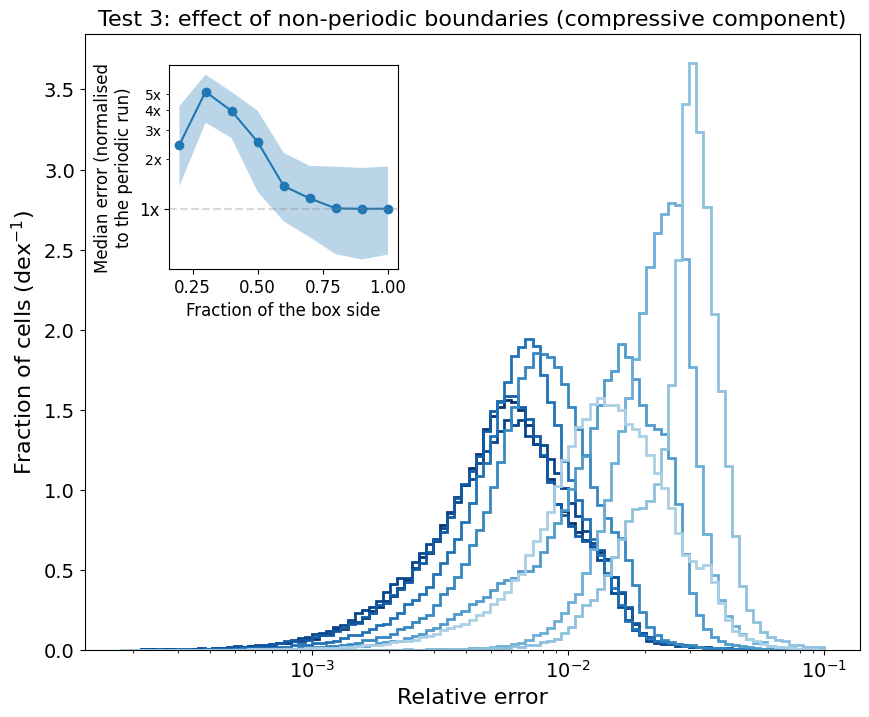

In [101]:
fig, ax = plt.subplots(1,1, figsize=(10,8))
fontsize_small = 14
fontsize_big = 16
fontsize_smaller = 12

path = 'test_data/periodicity/src'
it=0
size0=1.

irel=1
kernel = 'C4'
ngh=137

filepath='test_data/particles/particles_2e6.dat'
if os.path.exists(filepath):
    print('Warning!!! The file already exists. Reading it')
    with open(filepath, 'rb') as f:
        res=pickle.load(f)
        xpart=res['xpart'].astype('f4')
        ypart=res['ypart'].astype('f4')
        zpart=res['zpart'].astype('f4')
        mpart=res['mpart']
        hpart=res['hsml']
        
    print('File read!')

fracs = [1.0, 0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]
errmed = {}
errlow = {}
errhigh = {}
for ifrac, frac_length in enumerate(fracs):
    size = size0#*frac_length
    ### Error in the solenoidal velocity as in Test 3 
    results_path2 = os.path.join(path, 'output_files_{:.2f}'.format(frac_length))
    with FF(os.path.join(results_path2, 'velocity-particles{:05d}'.format(it))) as f:
        _=f.read_vector('i4')
        res_xpart=f.read_vector('f4')+size/2
        res_ypart=f.read_vector('f4')+size/2
        res_zpart=f.read_vector('f4')+size/2
        res_vxpartori=f.read_vector('f4')
        res_vypartori=f.read_vector('f4')
        res_vzpartori=f.read_vector('f4')
        _=f.read_vector('f4')
        del _
        res_vx=f.read_vector('f4')
        res_vy=f.read_vector('f4')
        res_vz=f.read_vector('f4')
        res_vxcomp=f.read_vector('f4')
        res_vycomp=f.read_vector('f4')
        res_vzcomp=f.read_vector('f4')
        res_vxrot=f.read_vector('f4')
        res_vyrot=f.read_vector('f4')
        res_vzrot=f.read_vector('f4')

        vxpart = np.sin(2*np.pi*res_xpart) + np.sin(4*np.pi*res_ypart) + np.sin(6*np.pi*res_zpart)
        vypart = np.sin(6*np.pi*res_xpart) + np.sin(2*np.pi*res_ypart) + np.sin(4*np.pi*res_zpart)
        vzpart = np.sin(4*np.pi*res_xpart) + np.sin(6*np.pi*res_ypart) + np.sin(2*np.pi*res_zpart)

        #vxpartcomp = np.sin(2*np.pi*res_xpart)
        #vxpartsol = res_vxpartori - vxpartcomp
        #vypartcomp = np.sin(2*np.pi*res_ypart)
        #vypartsol = res_vypartori - vypartcomp
        #vzpartcomp = np.sin(2*np.pi*res_zpart)
        #vzpartsol = res_vzpartori - vzpartcomp
        bor = frac_length/2
        select = (np.abs(xpart-size0/2)<bor) * (np.abs(ypart-size0/2)<bor) * (np.abs(zpart-size0/2)<bor)
        if select.sum() != res_vx.size:
            print('aaaaa')
            if select.sum() > res_vx.size:
                print('extra select')
            else:
                print('missing select')
                i=0
                for j in range(select.size):
                    if select[j]:
                        i+=1 
                    else:
                        dista=max(np.abs(res_xpart[i]-xpart[j]), np.abs(res_ypart[i]-ypart[j]), np.abs(res_zpart[i]-zpart[j]))
                        if dista<1e-5:
                            select[j]=True
                            print('found one')
        #tol=1e-7
        #select = (np.abs(np.abs(xpart-size0/2)-bor) < tol) * (np.abs(np.abs(ypart-size0/2)-bor) < tol) * (np.abs(np.abs(zpart-size0/2)-bor) < tol)

        vxpartcomp = smooth_velocities[irel][kernel][ngh]['vx_conp'][select]
        vypartcomp = smooth_velocities[irel][kernel][ngh]['vy_conp'][select]
        vzpartcomp = smooth_velocities[irel][kernel][ngh]['vz_conp'][select]
        vxpartsol = smooth_velocities[irel][kernel][ngh]['vx_sol'][select]
        vypartsol = smooth_velocities[irel][kernel][ngh]['vy_sol'][select]
        vzpartsol = smooth_velocities[irel][kernel][ngh]['vz_sol'][select]

    #bor=0.05
    #select=(res_xpart>bor)*(res_ypart>bor)*(res_zpart>bor)*(res_xpart<boxsize-bor)*(res_ypart<boxsize-bor)*(res_zpart<boxsize-bor)
    region = 0.1
    select = (np.abs(res_xpart-size0/2) < region) * (np.abs(res_ypart-size0/2) < region) * (np.abs(res_zpart-size0/2) < region)

    # error wrt the original input velocity and not the smoothed one
    vmod2 = vxpartcomp**2 + vypartcomp**2 + vzpartcomp**2
    epsilon = 0.001*np.sqrt(vmod2.max())
    err=(vxpartcomp**4/vmod2**2)*(res_vxcomp-vxpartcomp)**2/(np.abs(vxpartcomp)+epsilon)**2 + \
        (vypartcomp**4/vmod2**2)*(res_vycomp-vypartcomp)**2/(np.abs(vypartcomp)+epsilon)**2 + \
        (vzpartcomp**4/vmod2**2)*(res_vzcomp-vzpartcomp)**2/(np.abs(vzpartcomp)+epsilon)**2

    nbins=100
    err=np.sqrt(err)
    err=err[select]
    dex_bins=3/nbins
    weight = 1/res_xpart.size
    linestyle='solid'
    countsbins=ax.hist(err,bins=np.logspace(-3.75,-1, nbins), histtype='step', label='$x \in [{:.2f},{:.2f}]$'.format(-frac_length/2, frac_length/2),
        color=cm.Blues_r(0.75*ifrac/len(fracs)), linewidth=2, weights=weight*np.ones(select.sum())/dex_bins/select.mean(), linestyle=linestyle)
    print(irel, nbins, weight, dex_bins, (countsbins[0]*(np.log10(countsbins[1][1:])-np.log10(countsbins[1][:-1]))).sum())
    
    #plt.axvline(np.median(err),  color=cm.tab20c(4*ikernel+ingh))
    print(kernel + '\t {:} \t {:.2e} \t {:.2e} \t {:.2e} \t {:.2e}'.format(ngh, err.mean(), *[np.percentile(err, p) for p in [16,50,84]]))
    errmed[ifrac] = np.percentile(err, 50)
    errlow[ifrac] = np.percentile(err, 16)
    errhigh[ifrac] = np.percentile(err, 84)
            
for ifrac,_ in enumerate(fracs):
    if ifrac==0:
        mednorm = errmed[ifrac]
        lownorm = errlow[ifrac]
        highnorm = errhigh[ifrac]

        errmed[ifrac] = 1.
        errlow[ifrac] /= mednorm
        errhigh[ifrac] /= mednorm
    else:
        bkp = errmed[ifrac]
        errmed[ifrac] /= mednorm
        errlow[ifrac] /= mednorm
        errhigh[ifrac] /= mednorm

ax.set_xscale('log')
ax.set_yscale('linear')

#ax.legend(fontsize=fontsize_smaller, loc='lower left', 
#          title='Region extracted\nto run vortex-p')
# increase legend title fontsize 
#plt.setp(ax.get_legend().get_title(),fontsize=fontsize_smaller)

ax2=inset_axes(ax, width="37%", height="55%", loc=2,                   
            bbox_to_anchor=(0.1, 0.36,0.8,0.6),
            bbox_transform=ax.transAxes)
ax2.plot(fracs, errmed.values(), marker='o', linestyle='solid')
ax2.fill_between(fracs, errlow.values(), errhigh.values(), alpha=0.3)
ax2.set_yscale('log')
ax2.set_yticks([1.], minor=False)
ax2.set_yticklabels(['1x'])
ax2.set_yticks([2.,3.,4.,5.], minor=True)
ax2.set_yticklabels(['2x','3x','4x', '5x'], minor=True)
ax2.axhline(1., color='gray', linestyle='dashed', alpha=0.3)
ax2.set_xlabel('Fraction of the box side', fontsize=fontsize_smaller)
ax2.set_ylabel('Median error (normalised\nto the periodic run)',
                fontsize=fontsize_smaller)
ax2.tick_params(labelsize=fontsize_smaller)
#ax22 = ax2.twiny()
#ax22.set_xlim(ax2.get_xlim())
#ax22.set_xticks(ax2.get_xticks())
#ax22.set_xticklabels(['{:.0f}'.format(frac/0.2) for frac in ax2.get_xticks()])
#ax22.set_xlabel('Times the region of interest', fontsize=fontsize_smaller)

ax.set_title('Test 3: effect of non-periodic boundaries (compressive component)', fontsize=fontsize_big)
ax.tick_params(labelsize=fontsize_small)
ax.set_xlabel('Relative error', fontsize=fontsize_big)
ax.set_ylabel('Fraction of cells (dex$^{-1}$)', fontsize=fontsize_big)

#fig.savefig('figures/non_periodic_boundaries_compressive.pdf', bbox_inches='tight')
